In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os

## Extract all the file under the specified path(maml_model)
In this code snippet, we are extracting all the files under the 'maml_model' directory and store the names of the models and history files separately.

- models: List of all files in the maml_model directory that contain both "maml" and "shots" in their name.
- history: List of all files in the maml_model directory that contain "history" in their name.

In [3]:
# 指定路徑
path = "./maml_model/"

# 獲取該路徑下的所有檔案名稱
files = os.listdir(path)

# 遍歷所有檔案，並輸出檔案名稱
list_models = []
list_losses = []
for file in files:
    if 'maml' in file and 'shots' in file:
        list_models.append(file)
    elif 'history' in file:
        list_losses.append(file)

## Data Processing
- `df_loss`: A dataframe containing information parsed from the file names of the history files.
- `df_model`: A dataframe containing information parsed from the file names of the model files.

`df_loss` and `df_model` are generated by splitting the file names using the underscore character as a delimiter and then assigning the resulting components to specific columns in the dataframes. The components include information such as the number of iterations, the number of tasks, the number of ways, and the number of shots used in the training of the models.

In [10]:
df_loss = pd.DataFrame(list(map(lambda x:x.split('_'), list_losses)), 
             columns=['prefix', 'n_iter','iter_text','n_tasks','tasks_text','n_ways', 'ways_text', 'n_shots','shots_text', 'id_npy'])
df_loss

,prefix,n_iter,iter_text,n_tasks,tasks_text,n_ways,ways_text,n_shots,shots_text,id_npy
0,history,50,iter,100,tasks,2,ways,10,shots,0.npy
1,history,50,iter,100,tasks,2,ways,10,shots,1.npy
2,history,50,iter,100,tasks,2,ways,10,shots,10.npy
3,history,50,iter,100,tasks,2,ways,10,shots,11.npy
4,history,50,iter,100,tasks,2,ways,10,shots,12.npy
...,...,...,...,...,...,...,...,...,...,...
691,history,50,iter,50,tasks,2,ways,5,shots,5.npy
692,history,50,iter,50,tasks,2,ways,5,shots,6.npy
693,history,50,iter,50,tasks,2,ways,5,shots,7.npy
694,history,50,iter,50,tasks,2,ways,5,shots,8.npy


In [9]:
df_model = pd.DataFrame(list(map(lambda x:x.split('_'), list_models)),
             columns=['prefix', 'n_iter','iter_text','n_tasks','tasks_text','n_ways', 'ways_text', 'n_shots','shots_text', 'id_npy'])
df_model

,prefix,n_iter,iter_text,n_tasks,tasks_text,n_ways,ways_text,n_shots,shots_text,id_npy
0,maml,50,iter,100,tasks,2,ways,10,shots,0.npy
1,maml,50,iter,100,tasks,2,ways,10,shots,1.npy
2,maml,50,iter,100,tasks,2,ways,10,shots,10.npy
3,maml,50,iter,100,tasks,2,ways,10,shots,11.npy
4,maml,50,iter,100,tasks,2,ways,10,shots,12.npy
...,...,...,...,...,...,...,...,...,...,...
691,maml,50,iter,50,tasks,2,ways,5,shots,5.npy
692,maml,50,iter,50,tasks,2,ways,5,shots,6.npy
693,maml,50,iter,50,tasks,2,ways,5,shots,7.npy
694,maml,50,iter,50,tasks,2,ways,5,shots,8.npy


## Calculate the Average Loss from Model Files:
1. Determine the parameter combinations to analyze.
2. Set up loops for:
    - The number of tasks
    - The number of shots
    - The number of models with the same parameters
3. Query the file names under a certain combination of parameters from `df_model`.
4. Load the models.
5. Calculate the average value of the loss across all models with the same parameters.

In [5]:
n_combinations = 3*6
n_meta_update = 60
loss_per_combination = np.zeros((n_combinations, n_meta_update))
count_comb = 0
n_tasks = [10, 50, 100]
n_shots = [1, 2, 5, 10, 30, 50]
for n_task in n_tasks:
    for n_shot in n_shots:
        temp = df_loss.query(f'n_tasks == "{n_task}" and n_shots == "{n_shot}"')
        if len(temp) == 0:
            continue
        files_per_comb = temp.apply(lambda x:'_'.join(x), axis =1).values
        ll = np.empty((len(files_per_comb), n_meta_update))
        for i in range(len(files_per_comb)):
            l = np.load(path+files_per_comb[i], allow_pickle=True).tolist()['loss']
            # print(l)
            ll[i] = l
        loss_per_combination[count_comb] = np.mean(ll, axis = 0)
        count_comb += 1

## Plot the average loss of the model with different combinations of parameters:
- Parameters:
    - N_tasks
    - N_shots<br>
    
For each combination of n_tasks and n_shots, the loop runs 30 times, and the average of 30 trials is taken as the final loss.
<br>
The code creates subplots and plots the average loss for each combination of n_tasks and n_shots. The x-axis represents the epochs, and the y-axis represents the loss.
<br>
The code also sets the title of each subplot to the corresponding combination of n_tasks and n_shots.

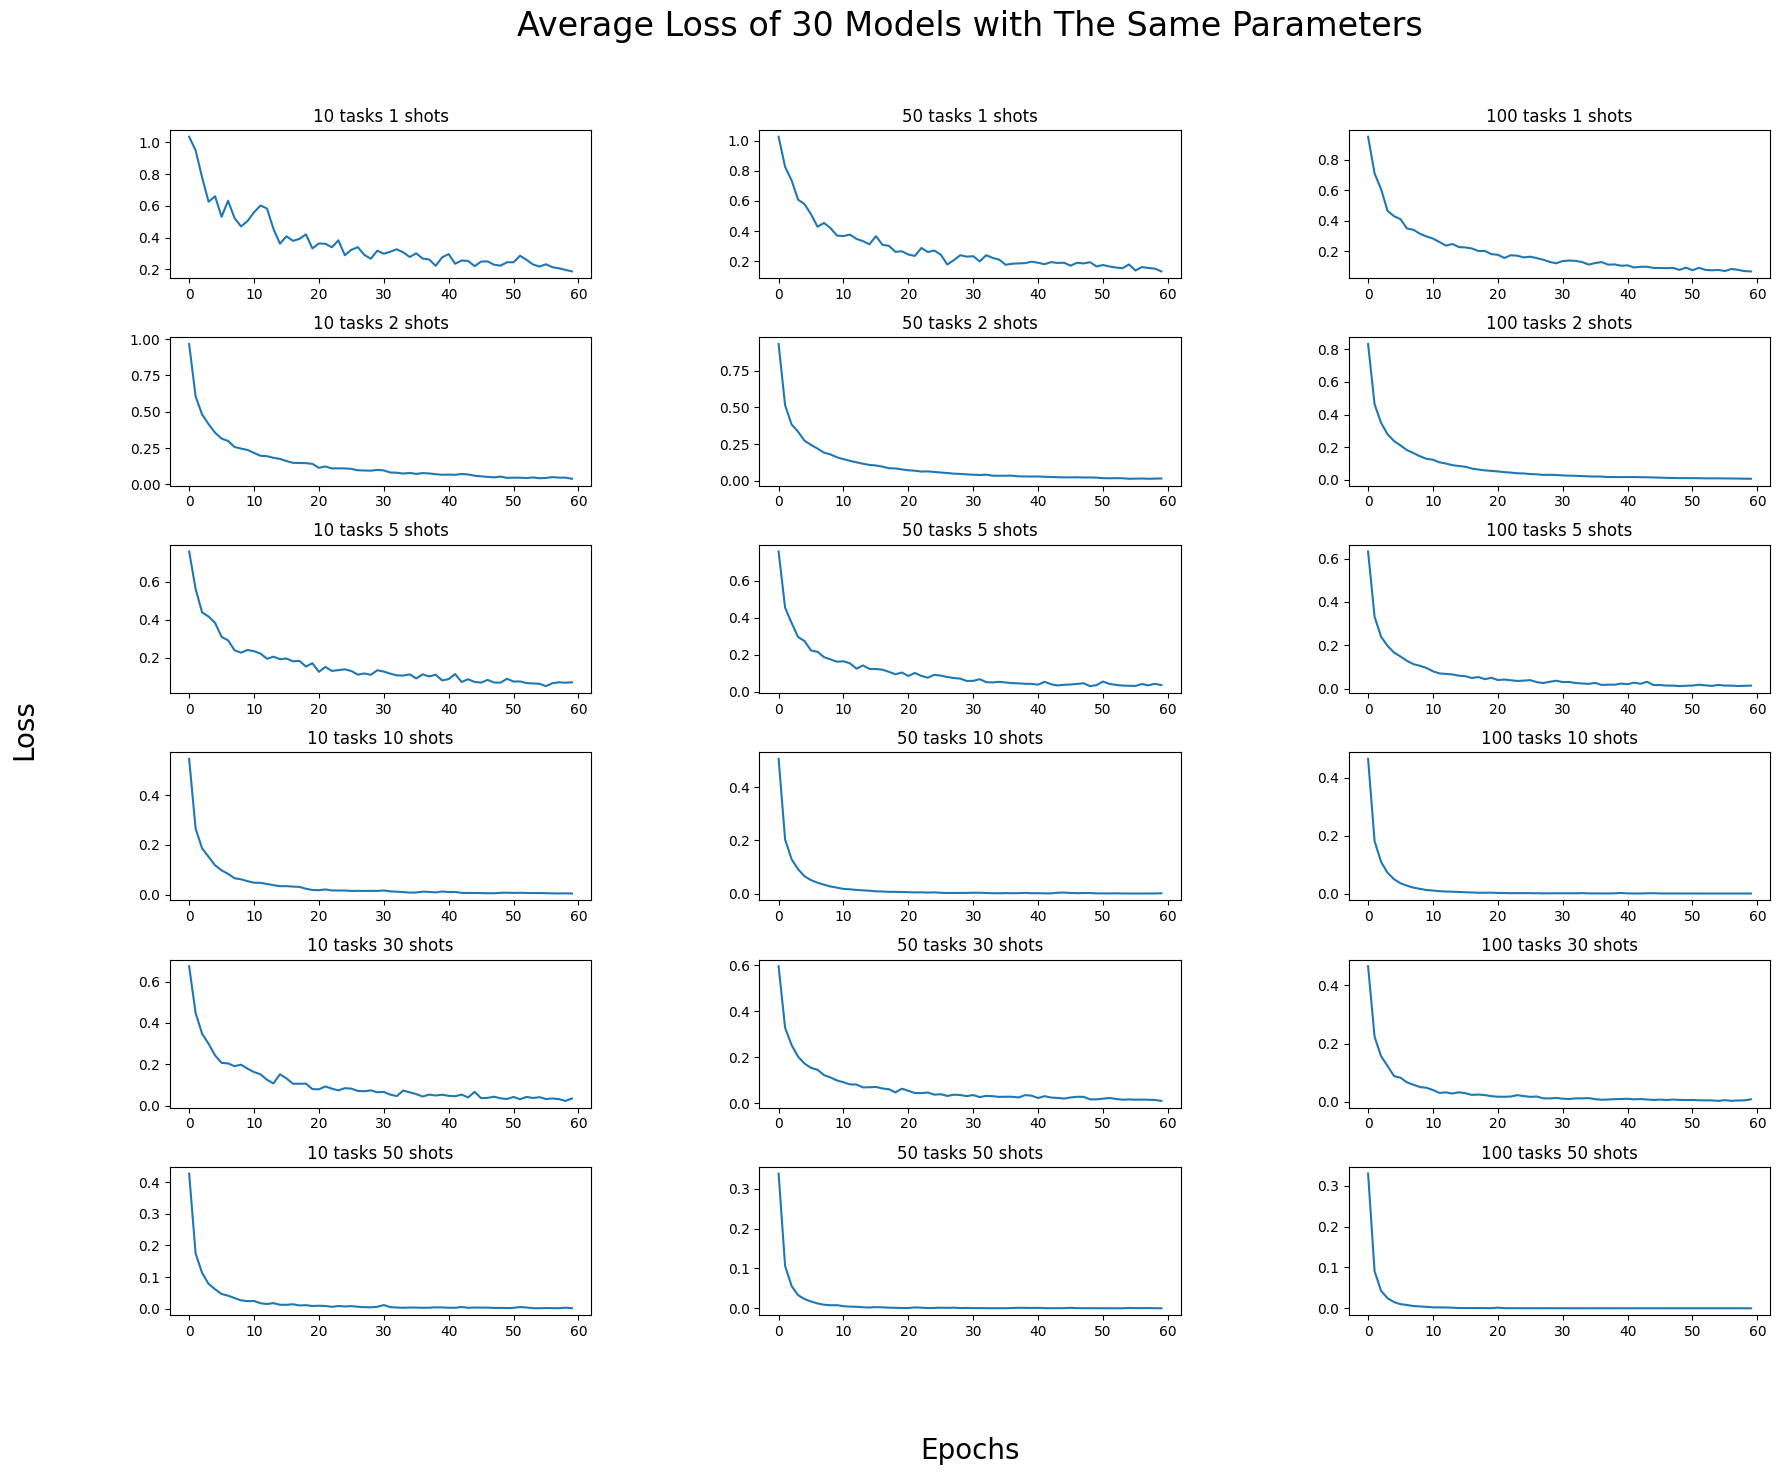

In [8]:
# 設置子圖片的行和列
rows, cols = 6, 3

# 創建子圖片
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))
fig.suptitle(f"Average Loss of 30 Models with The Same Parameters", fontsize = 24)
fig.supxlabel('Epochs', fontsize = 20)
fig.supylabel('Loss', fontsize = 20)

# 遍歷所有陣列，繪製子圖片
for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
    
        # 計算當前圖片的索引
        index = i * cols + j
        # 獲取當前陣列的數據
        x = loss_per_combination[index]
        # 繪製圖片
        ax.plot(x)
        ax.set_title(f"{n_tasks[j]} tasks {n_shots[i]} shots")
        # ax.set_ylabel("loss")
        # ax.set_xlabel("epoch")

# 調整子圖片間的間距和邊緣
plt.subplots_adjust(hspace=0.4, wspace=0.4, left=0.1, right=0.9, top=0.9)

# 顯示圖片
plt.show()

## Evaluate Model
- Accuracy
- Confusion Matrix
- ROC and AUC

In [11]:
from Credit_Maml import *
import tensorflow as tf

In [12]:
conn = sqlite3.connect('data_std.db')
scripts = '''select * from credit_default_pred'''
data_std = pd.read_sql(scripts, conn)
data_std

,A105,A106,A116,A401,A509,A511,A517,A519,A609,A611,...,R906,SUD1,T310,XCNL,XCPA,XCTL,XGRP,XMTG,XPYR,是否違約
0,0.155906,0.010461,-0.401397,-0.046266,0.334499,-0.142139,-0.087050,0.294049,-0.404180,-0.013853,...,1.216554,0.150698,2.683424,-0.377492,-0.135021,-1.164123,-0.662574,-0.795279,-0.114314,0.0
1,0.082568,0.010461,-0.430237,0.006949,0.437604,-0.142139,-0.090957,0.392044,-0.412637,-0.014003,...,1.443770,0.205122,2.886790,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
2,0.096319,0.010461,-0.427540,-0.012908,0.707057,-0.142139,-0.090957,0.648142,-0.415240,-0.014008,...,1.300948,0.259546,3.034055,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
3,0.371911,0.010463,-0.363939,-0.065520,1.092298,-0.142139,-0.065388,1.014289,-0.418615,-0.013812,...,1.239275,0.313970,3.041067,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
4,0.568435,0.010464,-0.386761,-0.014787,1.312830,-0.142139,-0.026679,1.223891,-0.421827,-0.013747,...,0.950386,0.368394,3.181319,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,-0.156928,0.010463,-0.490901,0.478554,0.136572,-0.142139,-0.015670,0.105932,-0.307407,-0.014542,...,2.154632,2.037036,-0.689642,-0.377492,-0.135021,-0.840627,-0.662574,0.733134,-0.114314,0.0
9144,-0.344858,0.010462,-0.457150,0.083593,-0.017524,-0.142139,-0.028100,-0.040526,-0.276993,-0.014539,...,2.719427,2.091460,-0.331999,-0.377492,-0.135021,-0.770471,-0.662574,1.602591,-0.114314,0.0
9145,-0.003949,0.010462,-0.603419,0.127576,0.538983,-0.142139,0.018066,0.488398,-0.265120,-0.014546,...,1.346392,2.145884,0.095770,-0.377492,-0.135021,-0.770471,-0.662574,1.661794,-0.114314,0.0
9146,-0.205056,0.010462,-0.425229,0.115165,0.206028,-0.142139,0.074176,0.171945,-0.266991,-0.014547,...,1.924170,2.200308,0.502502,-0.377492,-0.135021,-0.978711,-0.662574,1.668944,-0.114314,1.0


## Train/Test split
test/train ratio = 0.3

In [13]:
from sklearn.model_selection import train_test_split
X = data_std.loc[:,data_std.columns.difference(['是否違約'])]
y = data_std['是否違約']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Plot the confusion matrix and ROC curve of each parameter combination:
1. Declare the variable:
    - n_tasks: number of tasks.
    - n_shots: number of shots.
    - n_data: number of data.
2. Set up loops for:
    - The number of tasks.
    - The number of shots.
    - The number of models with the same parameters.
3. Query the file names under a certain combination of parameters from `df_model`.
<br>
4. Load the models.
<br>
5. Predict the result by the loaded models:
    - `val_model`: Make the prediction by the value of the weights of the model, which depends on the serial number.
    - `avg_model`: Make the prediction by the average value of the weights of 30 models.
    - `best_model`: Make the prediction by the minimum value of the weights among 30 models.
<br>
6. Calculate the loss and record the model with the minimun loss in each combination
<br>
7. Plot the confusion matrix and ROC curve of the `avg_model` and `best_model` separately.



Average
10 tasks and 1 shots
[0.00000000e+00 3.76506024e-04 1.00000000e+00] [0. 0. 1.] [2 1 0]
Best
10 tasks and 1 shots
[0.00000000e+00 3.76506024e-04 1.00000000e+00] [0. 0. 1.] [2 1 0]
Average
10 tasks and 2 shots
[0.00000000e+00 7.53012048e-04 1.00000000e+00] [0.         0.11363636 1.        ] [2 1 0]
Best
10 tasks and 2 shots
[0.         0.39759036 1.        ] [0.         0.86363636 1.        ] [2 1 0]
Average
10 tasks and 5 shots
[0.         0.00150602 1.        ] [0. 0. 1.] [2 1 0]
Best
10 tasks and 5 shots
[0.         0.39457831 1.        ] [0.         0.84090909 1.        ] [2 1 0]
Average
10 tasks and 10 shots
[0.         0.00150602 1.        ] [0. 0. 1.] [2 1 0]
Best
10 tasks and 10 shots
[0.         0.38478916 1.        ] [0.         0.84090909 1.        ] [2 1 0]
Average
10 tasks and 30 shots
[0.         0.00188253 1.        ] [0.         0.11363636 1.        ] [2 1 0]
Best
10 tasks and 30 shots
[0.         0.37876506 1.        ] [0.         0.88636364 1.        ] [2 1 0]
A

c:\Users\2022011702\Desktop\Leo\Credit Default Predict\Credit_Maml.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


Best
10 tasks and 50 shots
[0.         0.38629518 1.        ] [0.         0.90909091 1.        ] [2 1 0]
Average
50 tasks and 1 shots
[0.00000000e+00 7.53012048e-04 1.00000000e+00] [0. 0. 1.] [2 1 0]
Best
50 tasks and 1 shots
[0.         0.36746988 1.        ] [0.         0.79545455 1.        ] [2 1 0]
Average
50 tasks and 2 shots
[0.00000000e+00 7.53012048e-04 1.00000000e+00] [0.         0.11363636 1.        ] [2 1 0]
Best
50 tasks and 2 shots
[0.         0.37161145 1.        ] [0.         0.77272727 1.        ] [2 1 0]
Average
50 tasks and 5 shots
[0. 1.] [0. 1.] [1 0]
Best
50 tasks and 5 shots
[0.         0.37650602 1.        ] [0.         0.90909091 1.        ] [2 1 0]
Average
50 tasks and 10 shots
[0.         0.00150602 1.        ] [0. 0. 1.] [2 1 0]
Best
50 tasks and 10 shots
[0.         0.35240964 1.        ] [0.         0.88636364 1.        ] [2 1 0]
Average
50 tasks and 30 shots
[0.        0.0060241 1.       ] [0.         0.02272727 1.        ] [2 1 0]
Best
50 tasks and 30 sho

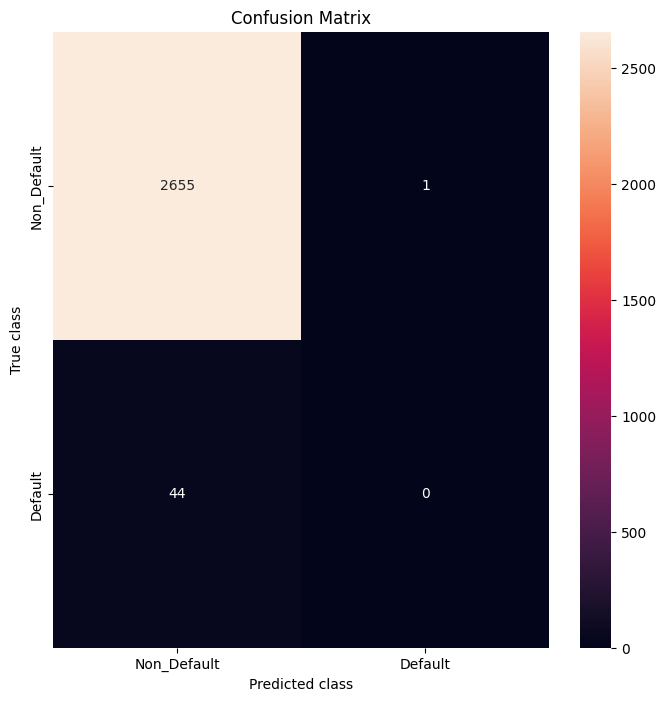

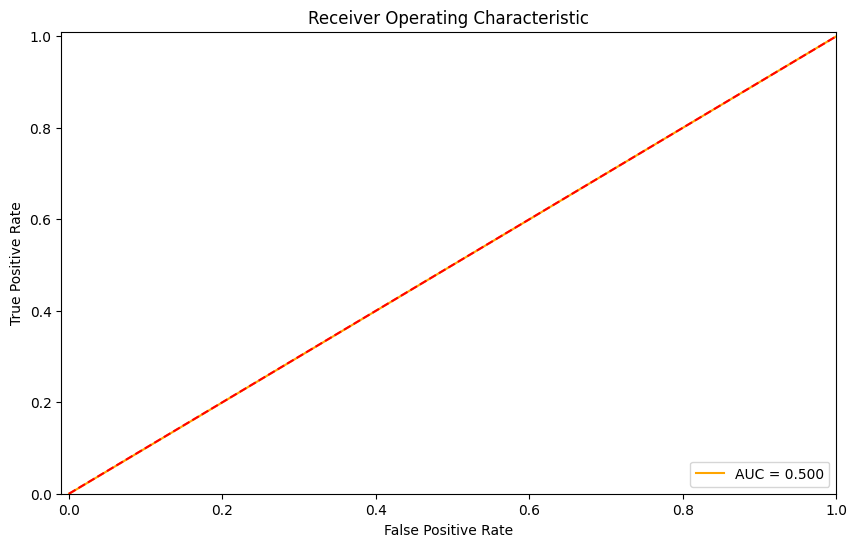

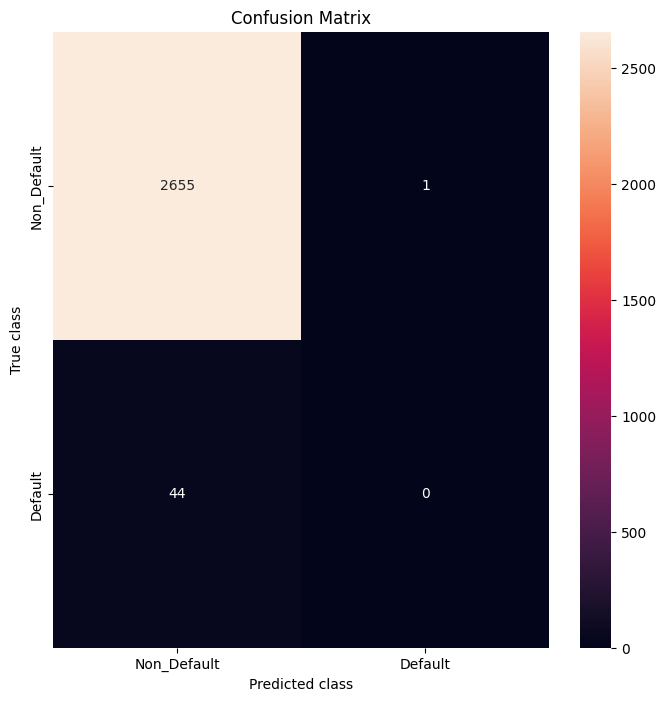

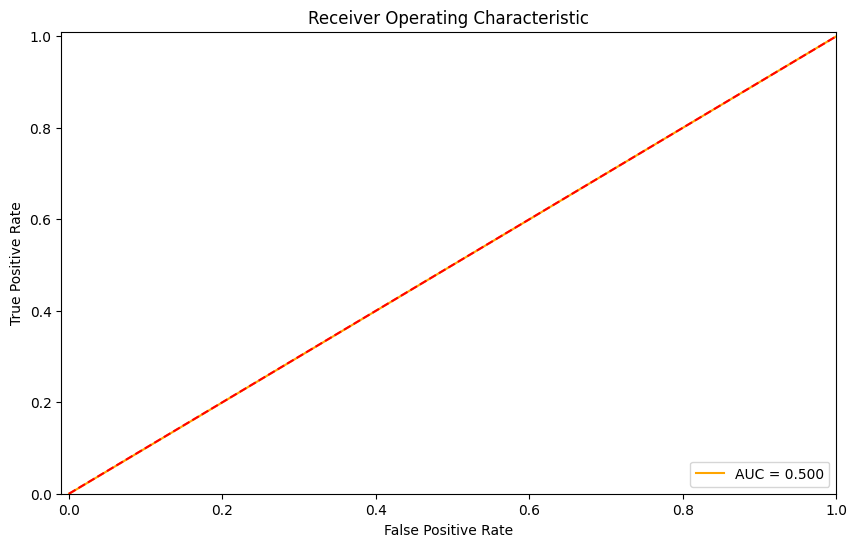

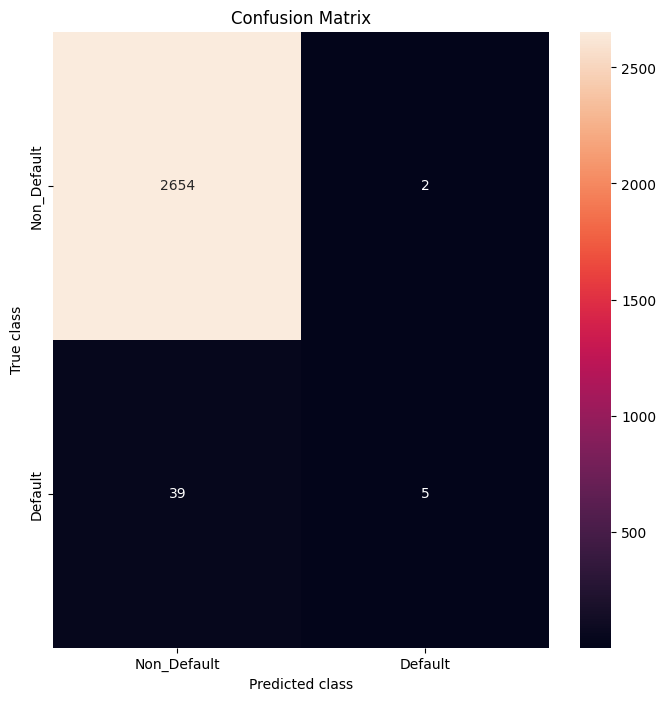

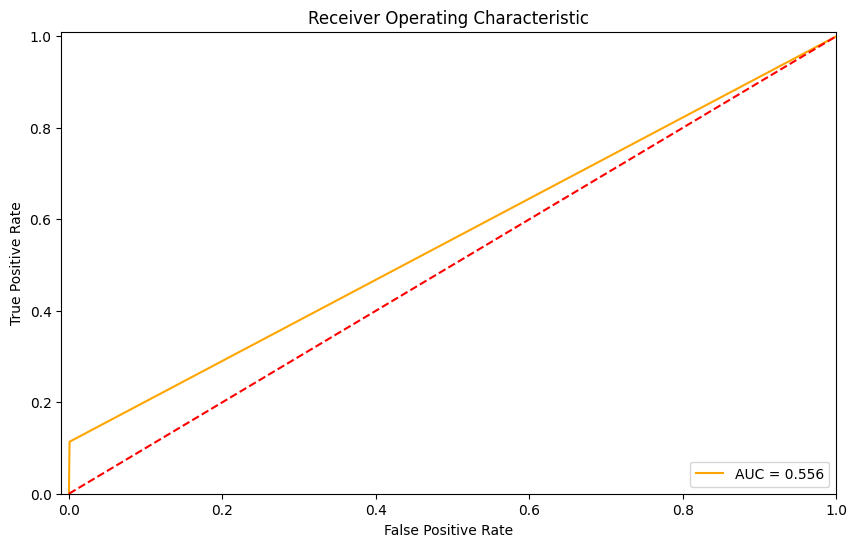

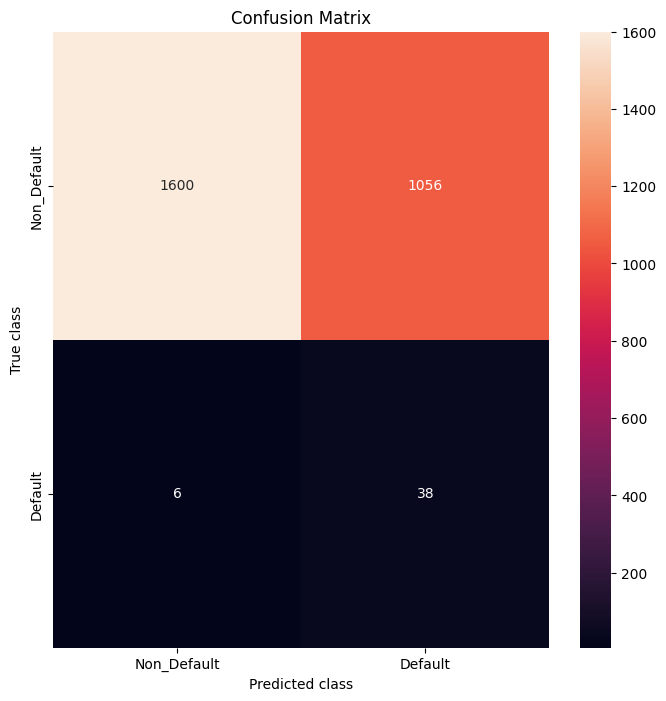

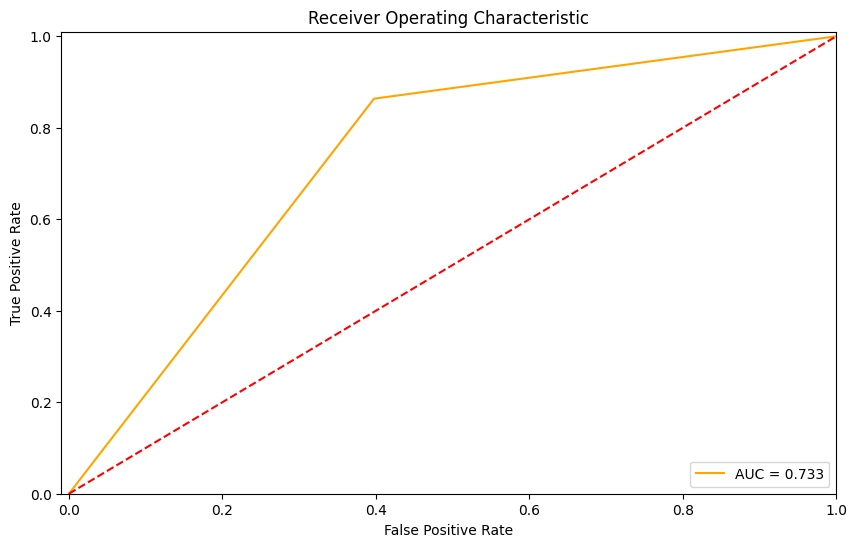

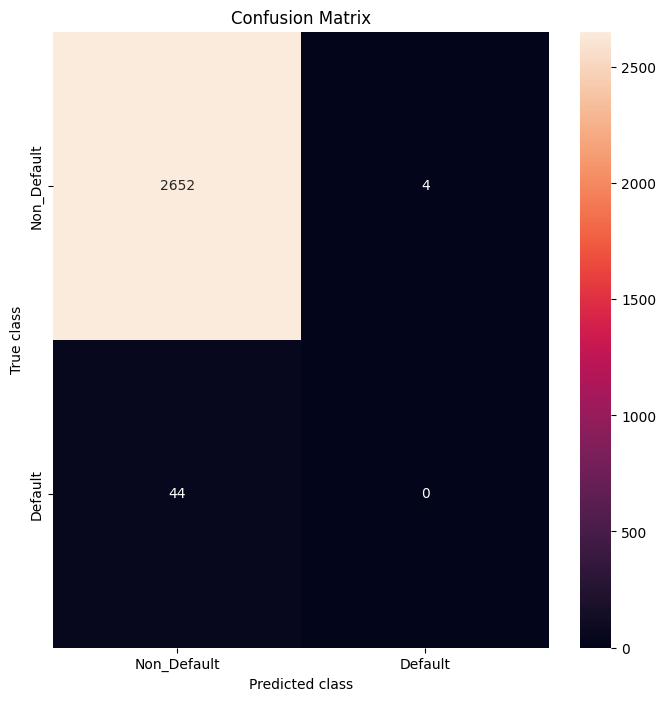

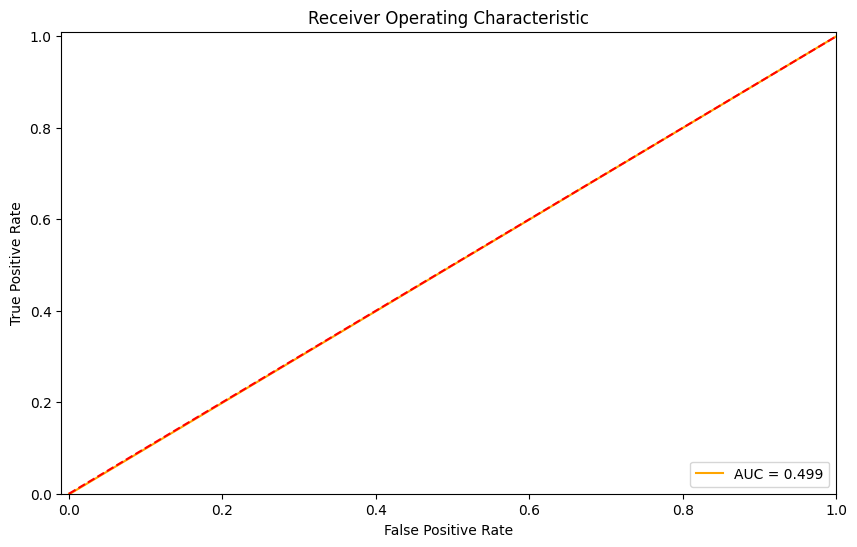

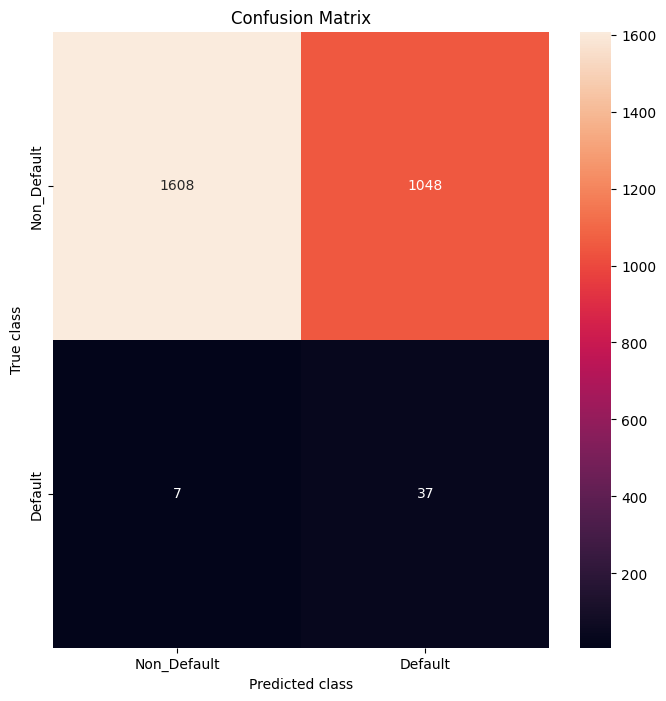

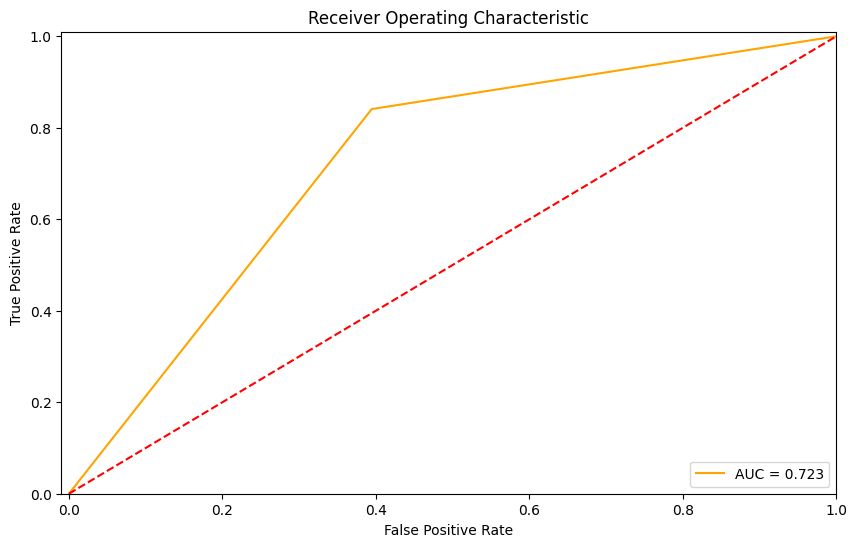

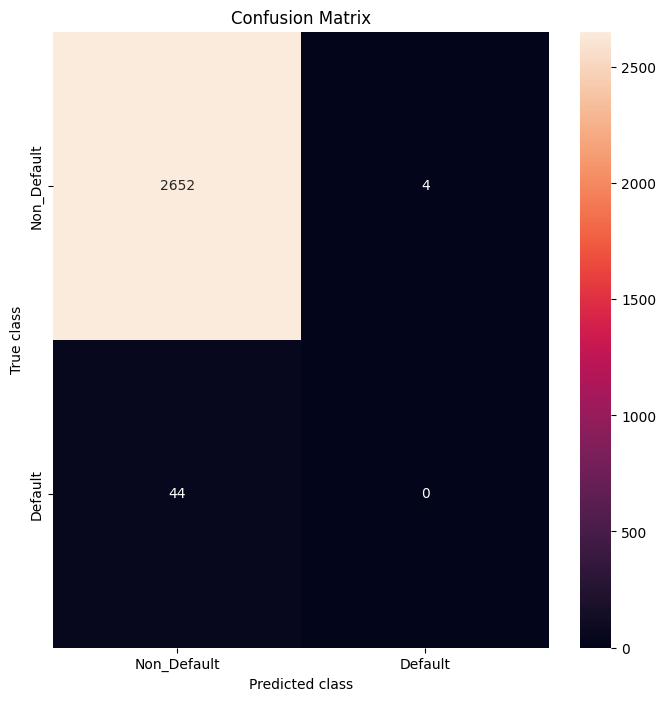

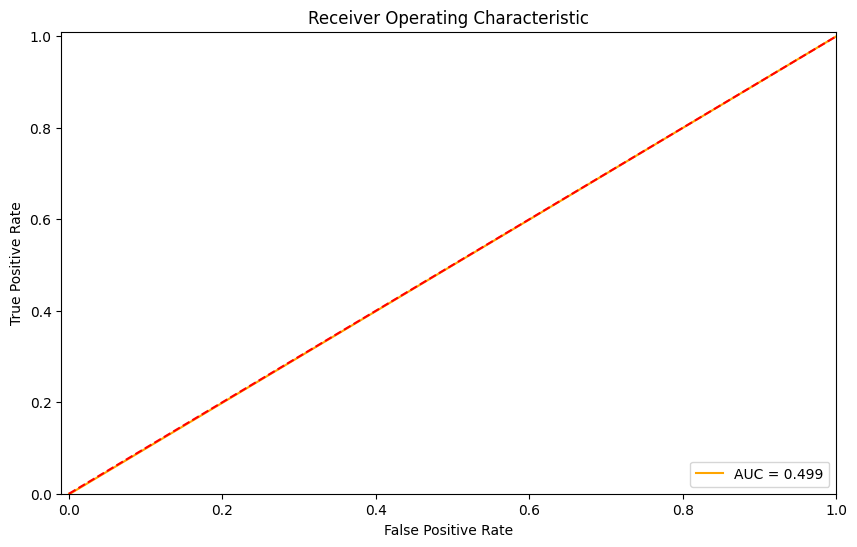

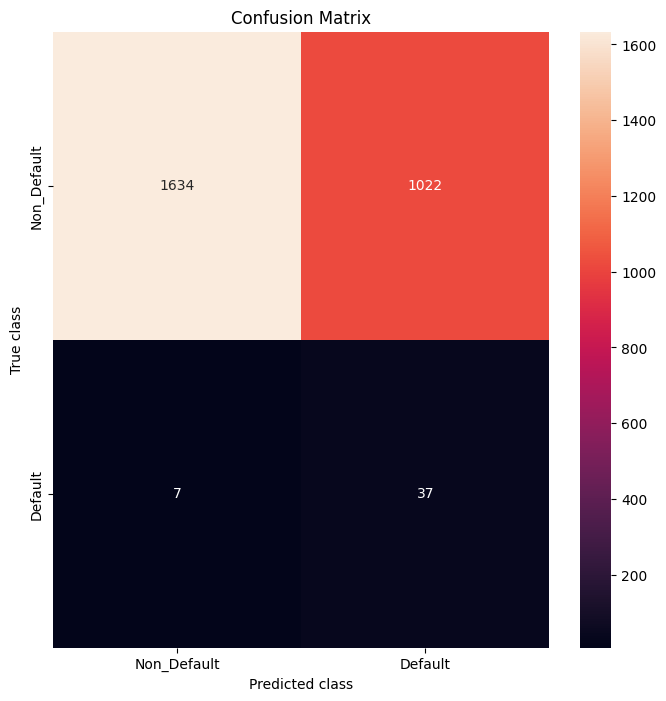

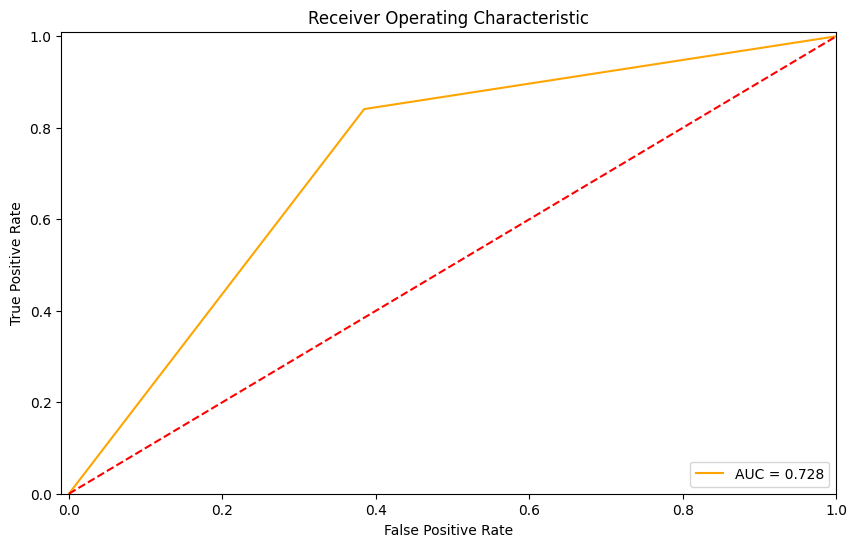

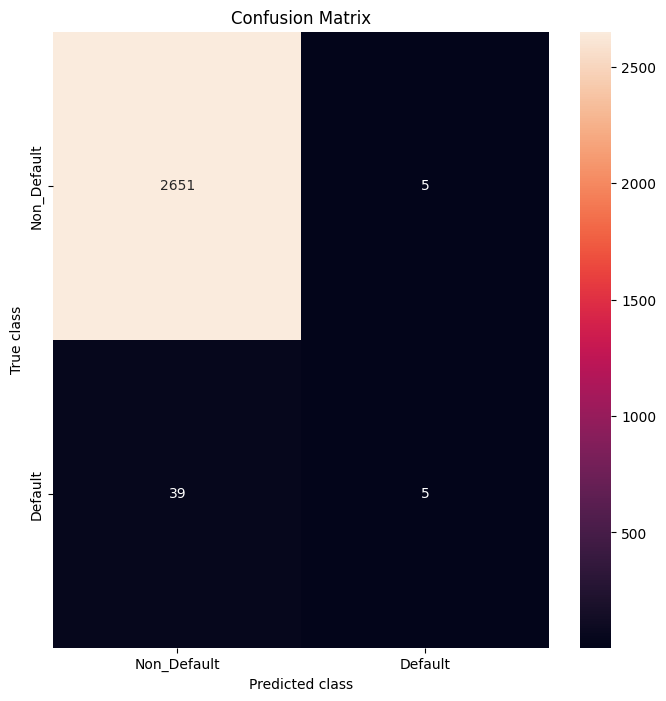

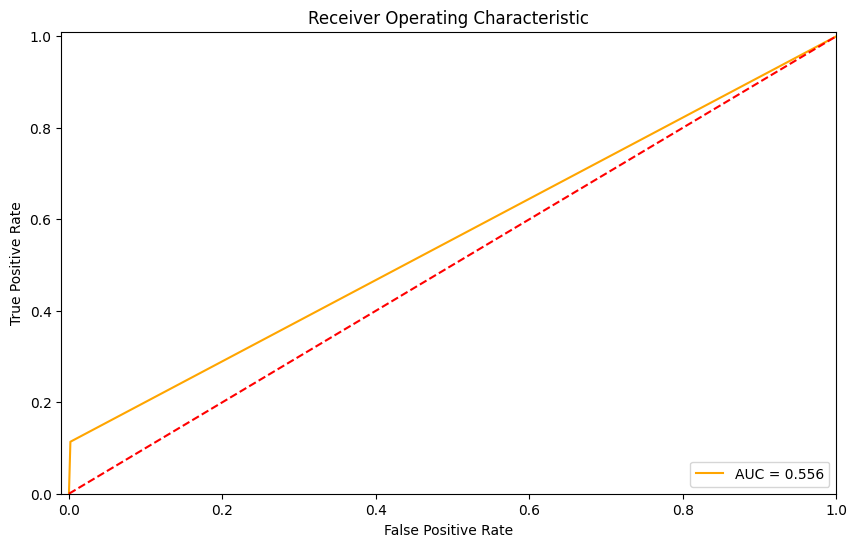

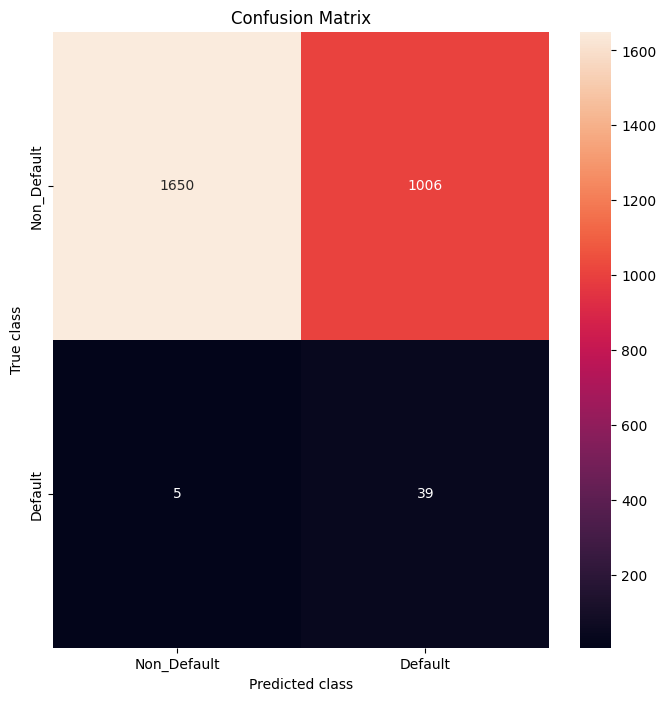

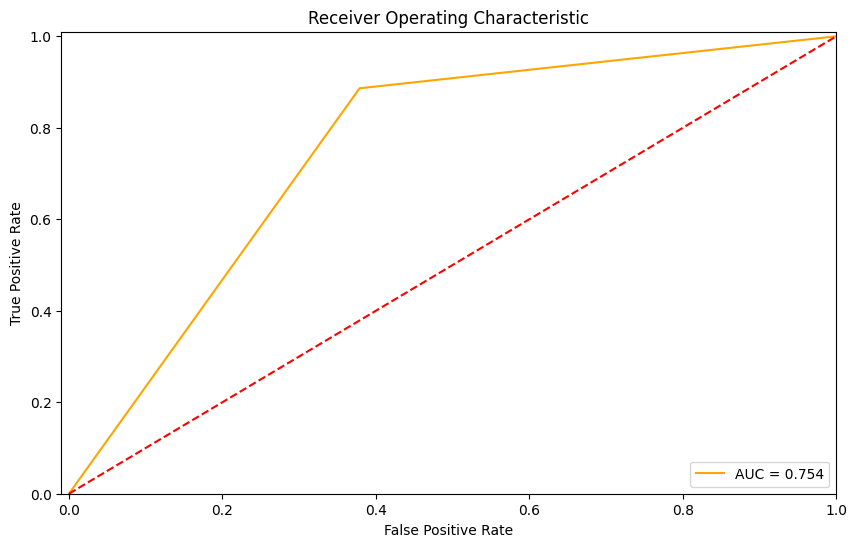

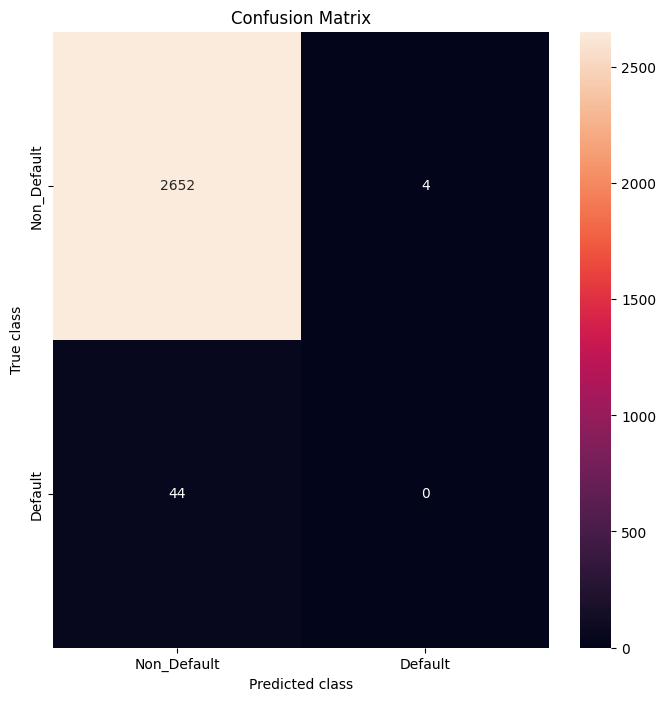

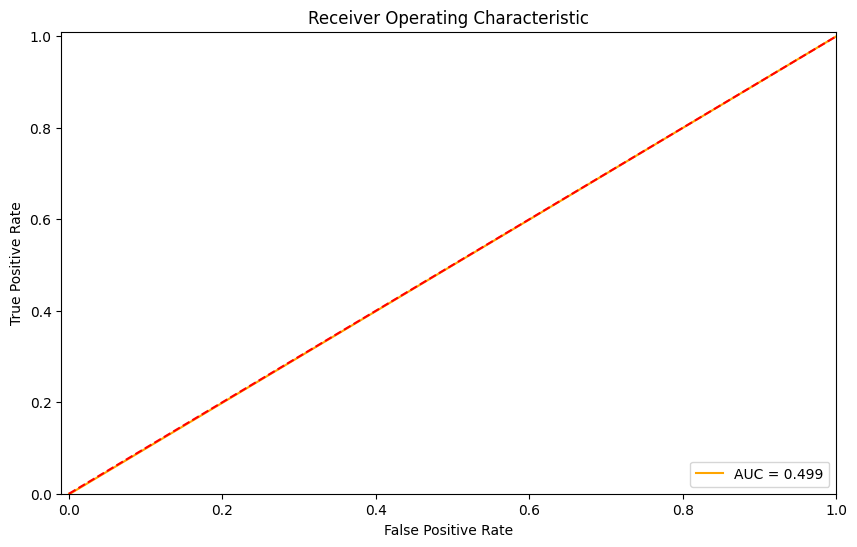

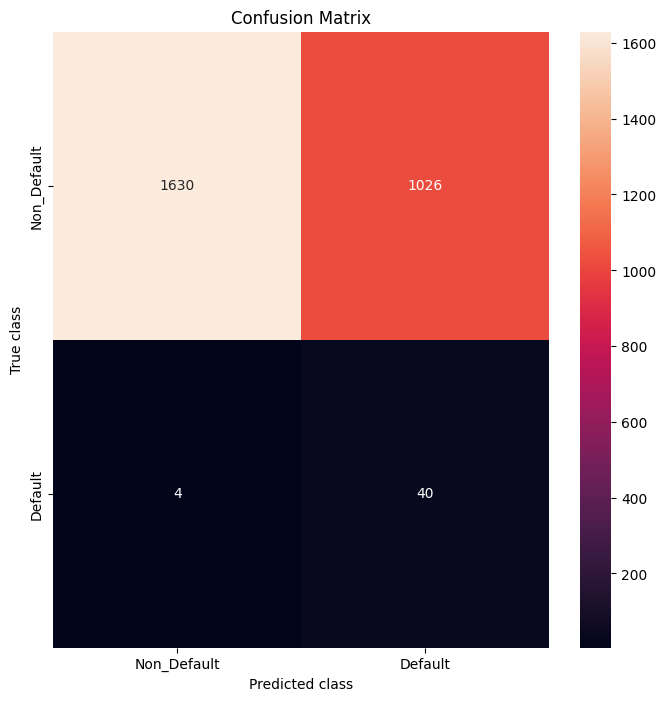

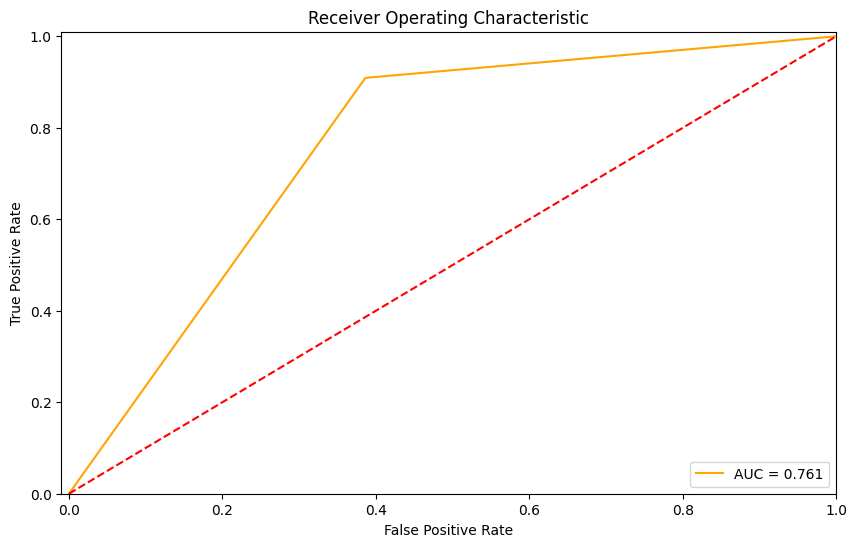

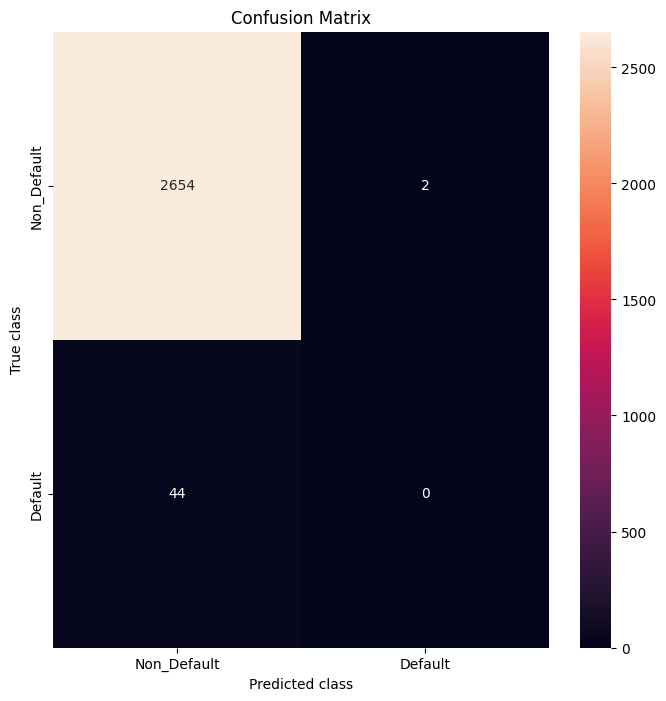

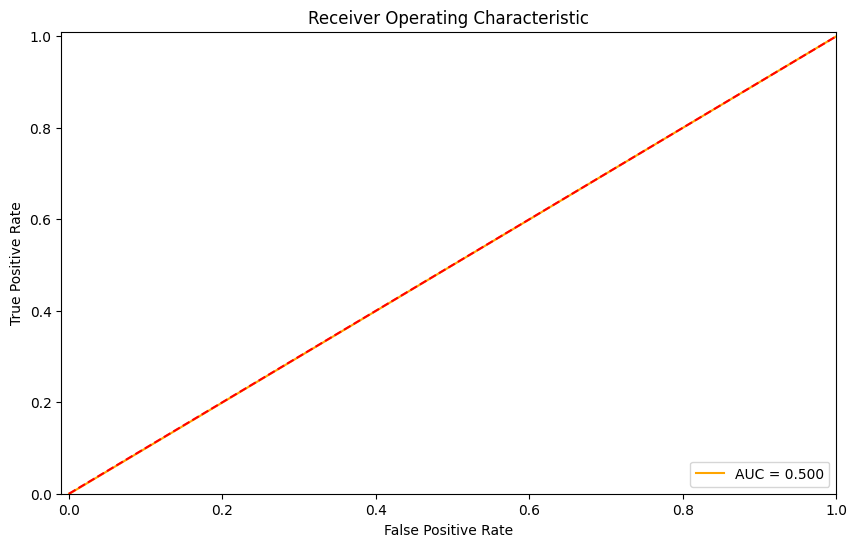

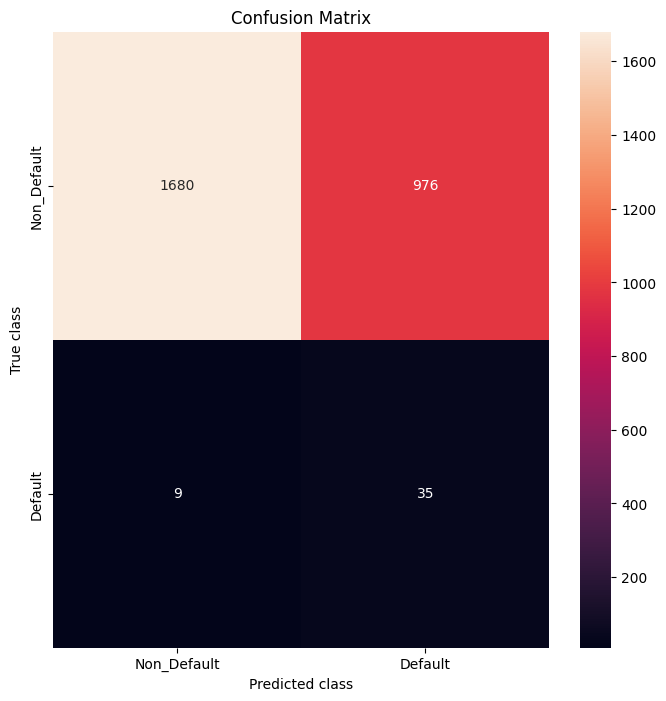

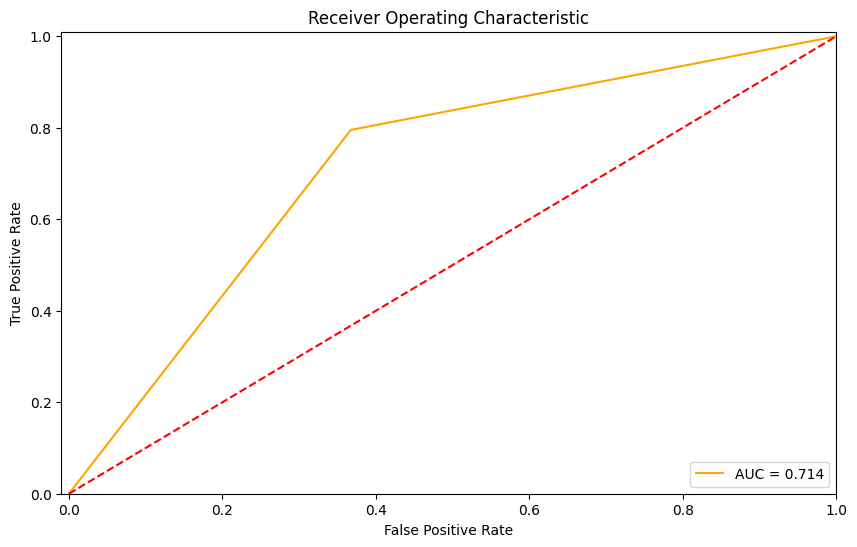

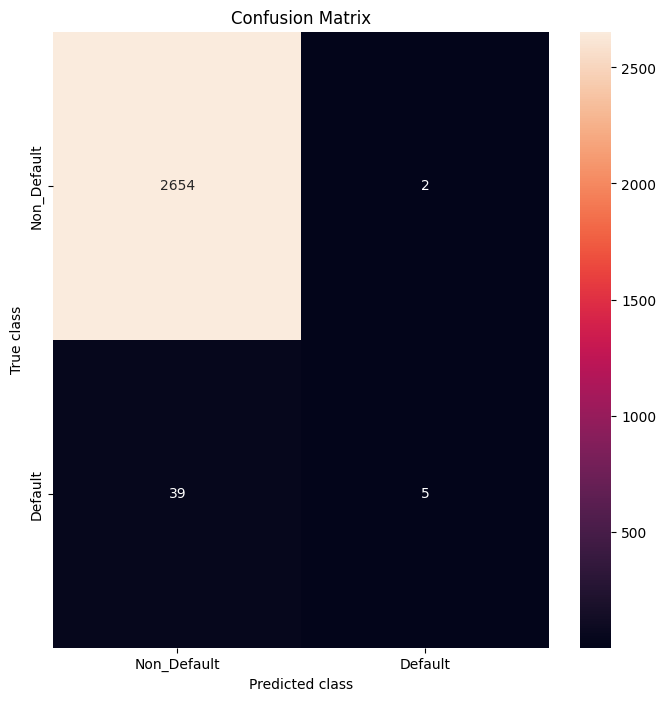

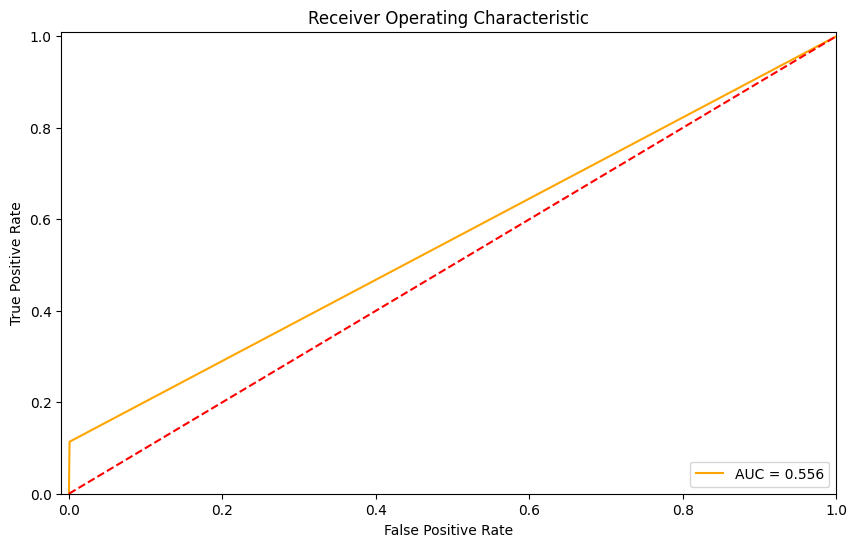

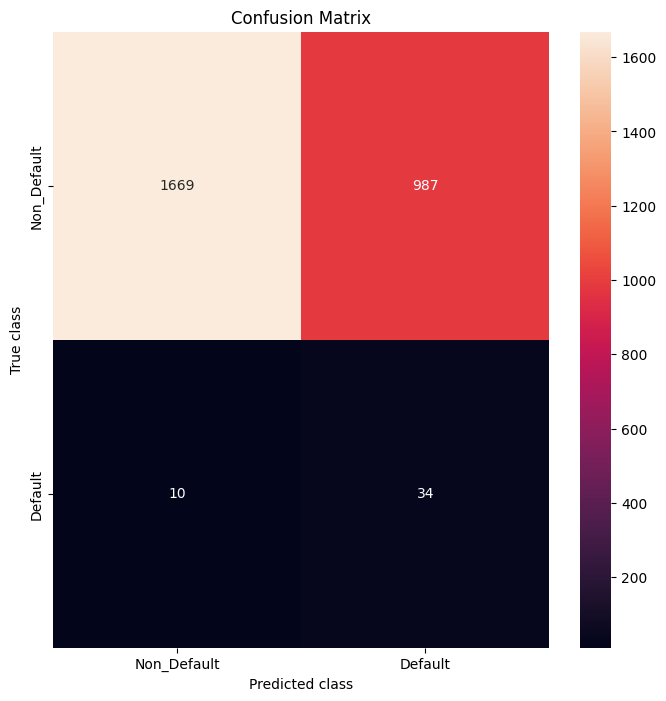

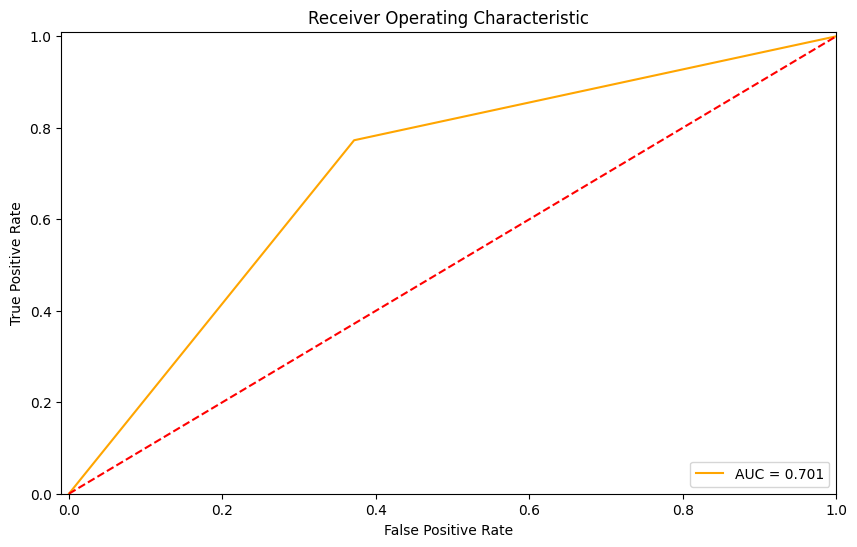

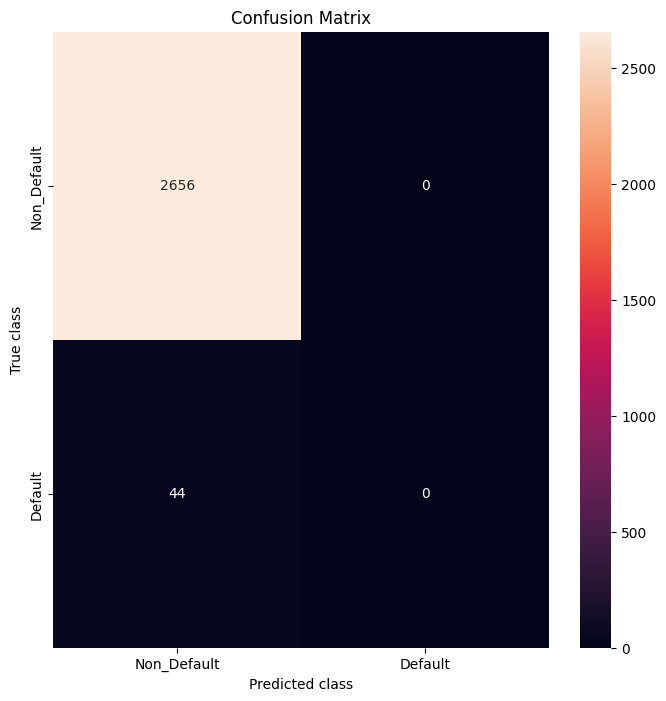

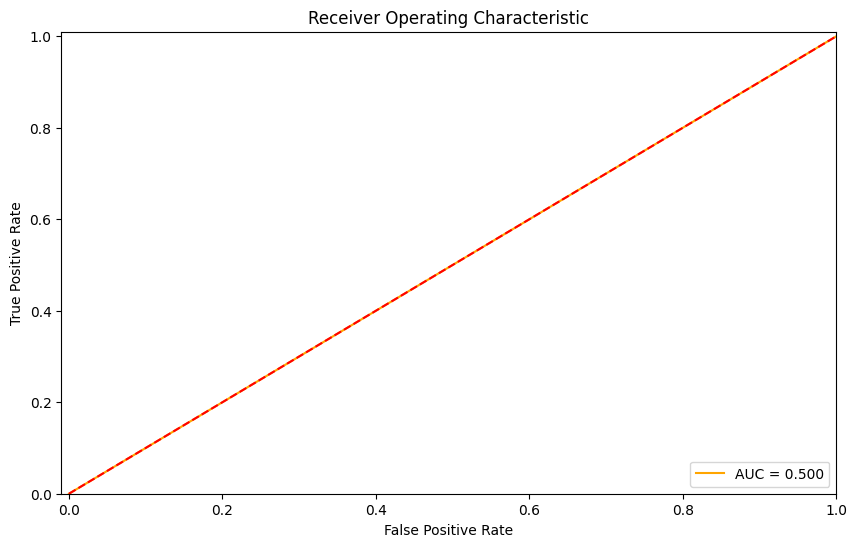

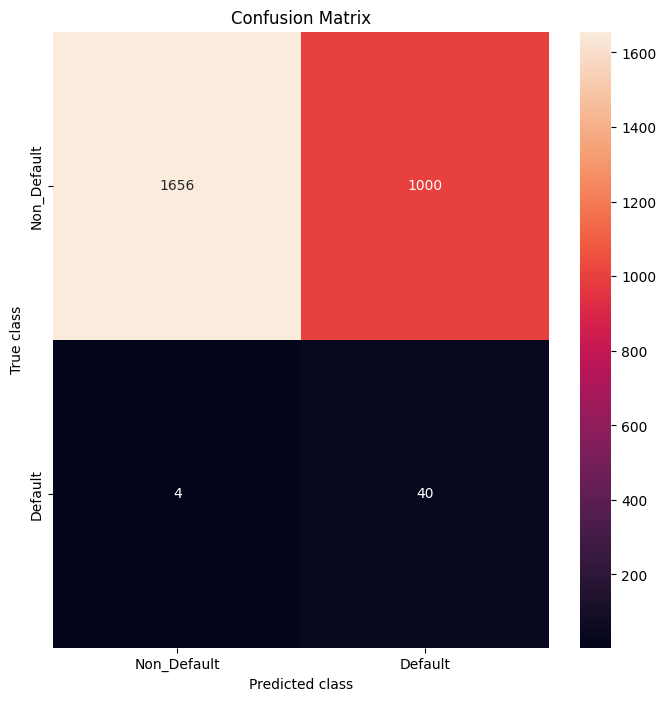

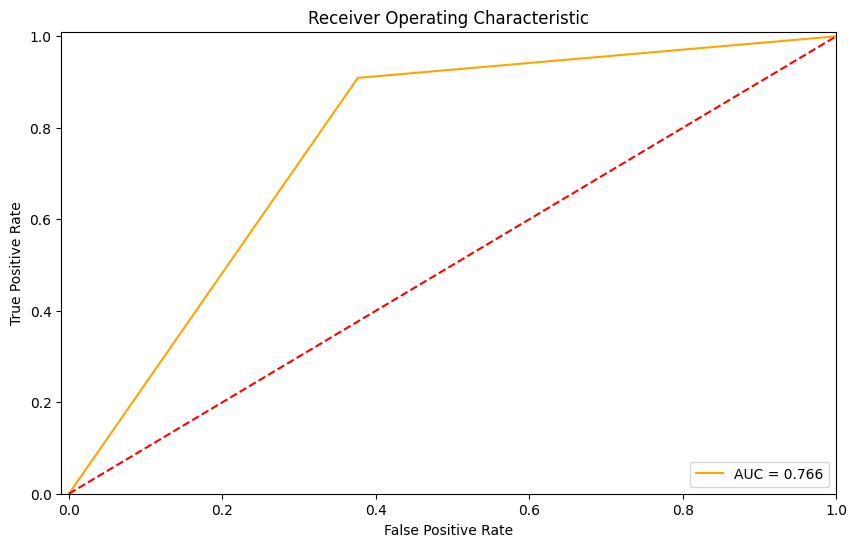

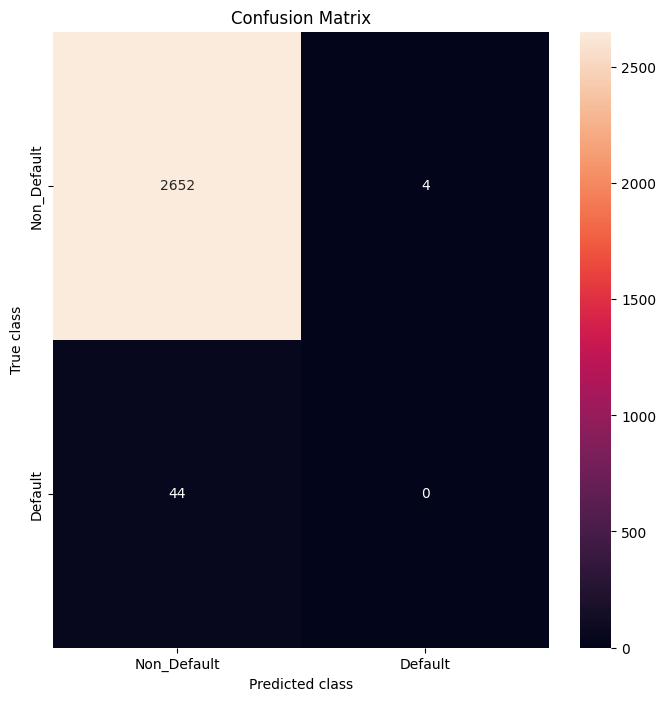

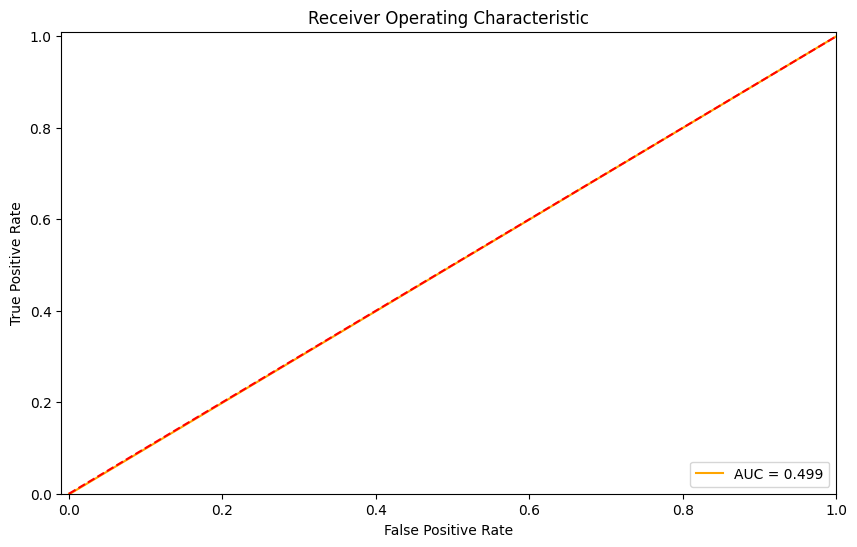

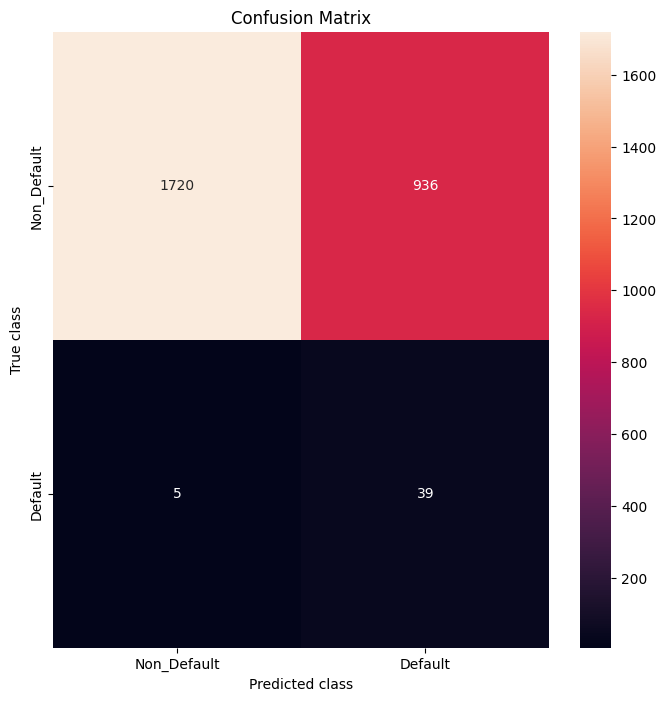

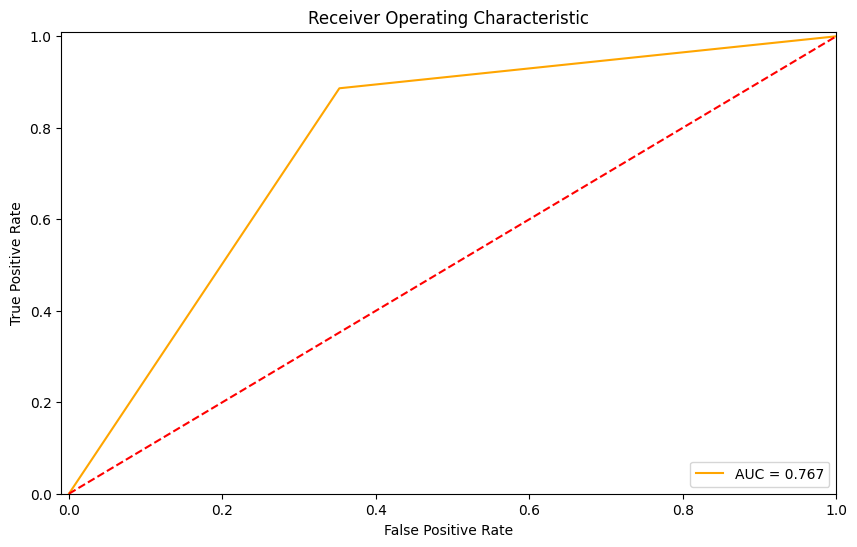

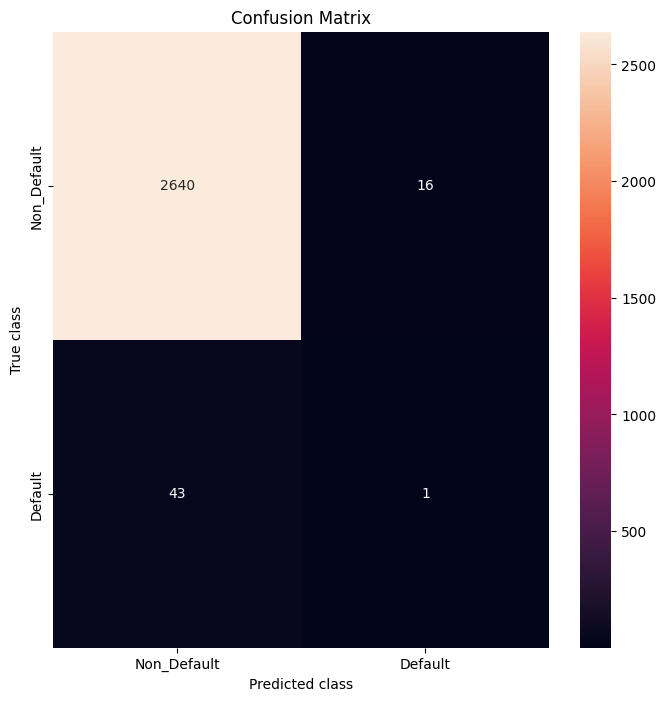

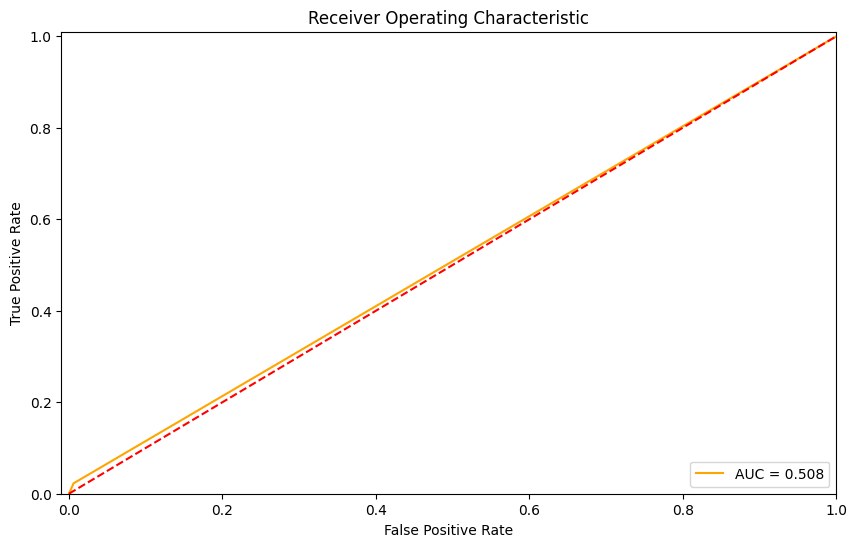

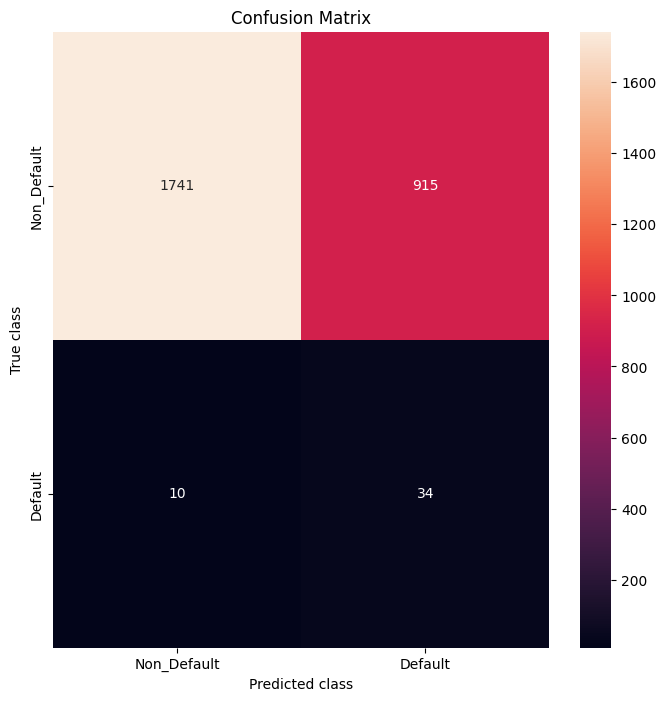

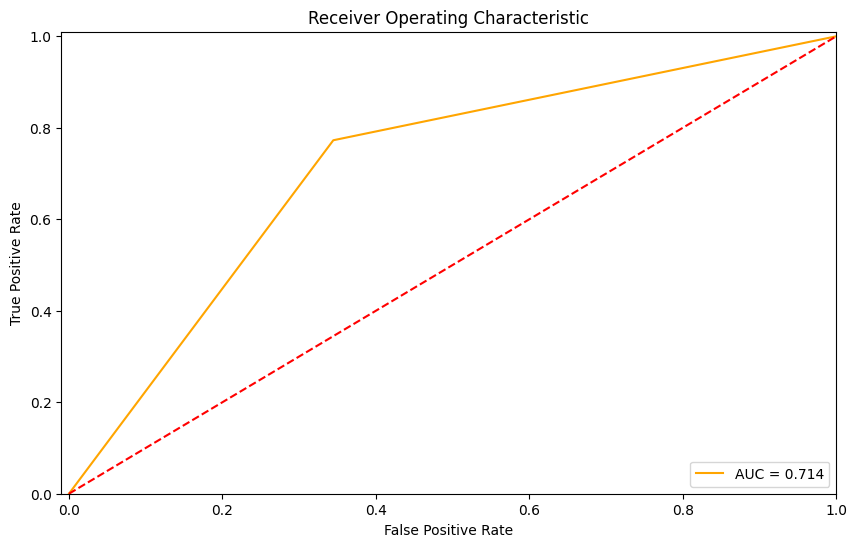

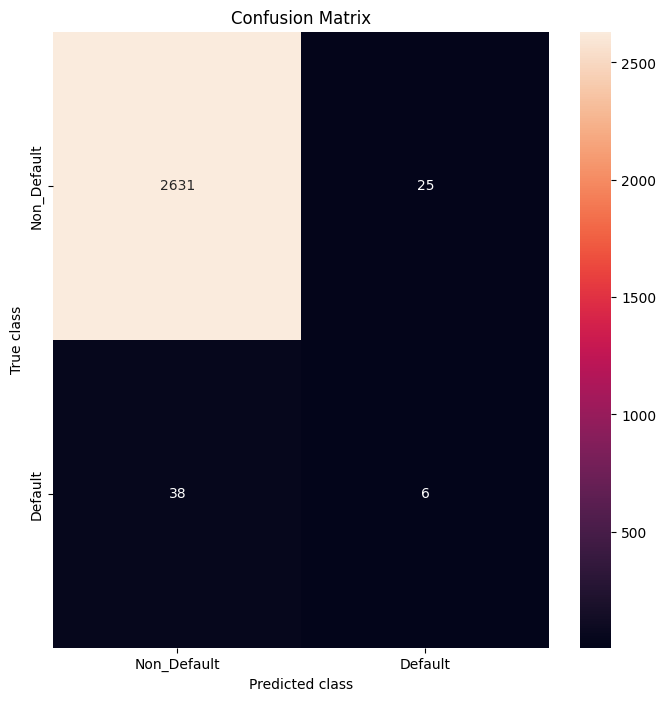

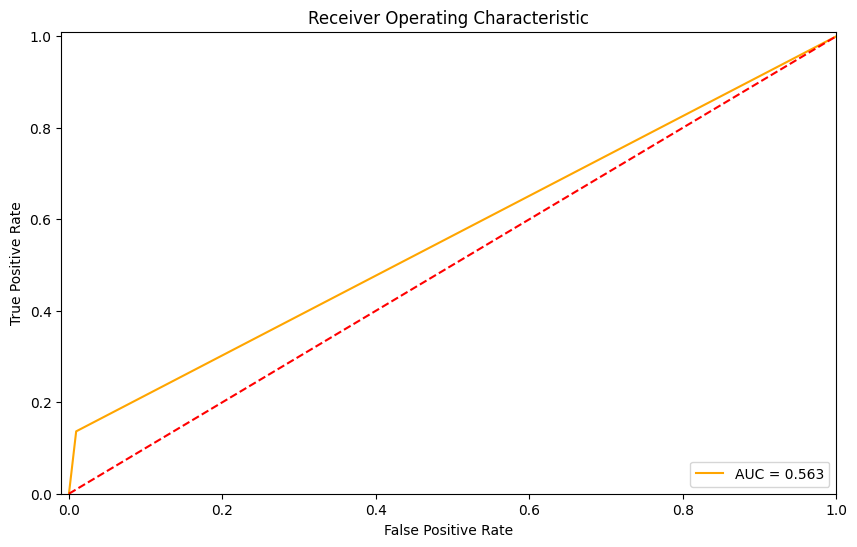

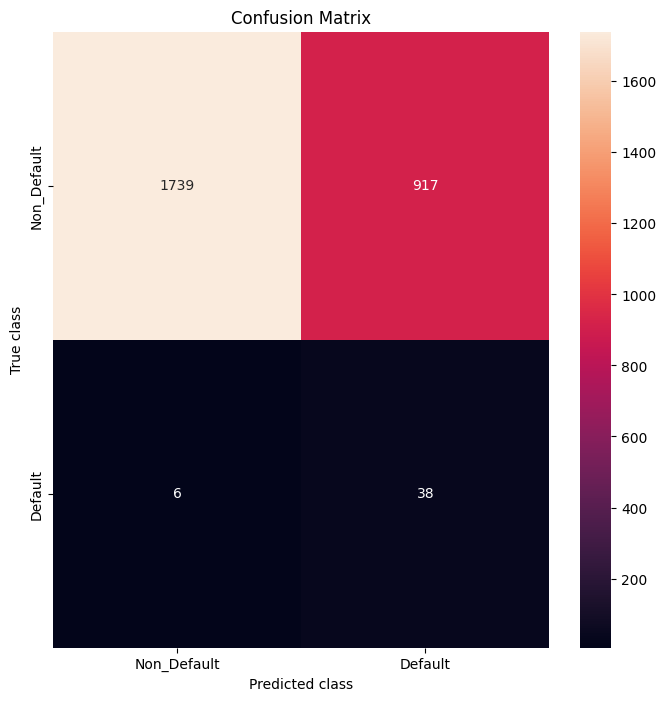

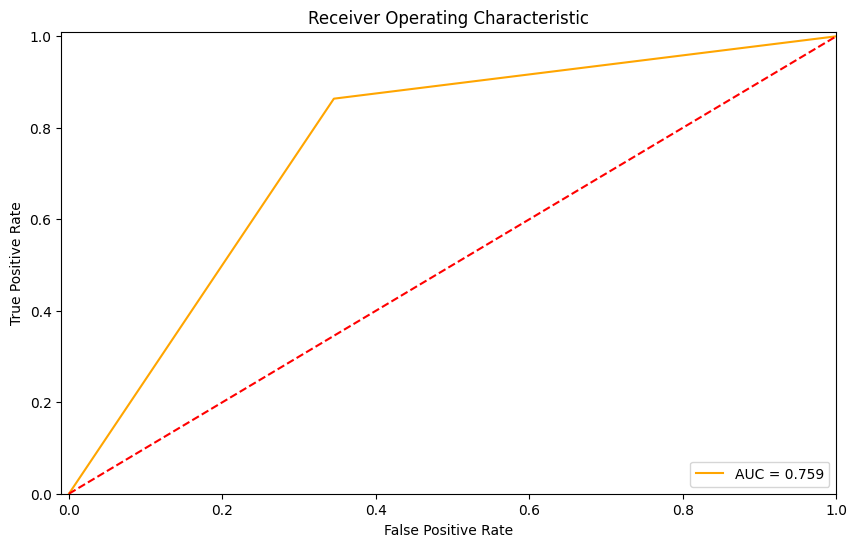

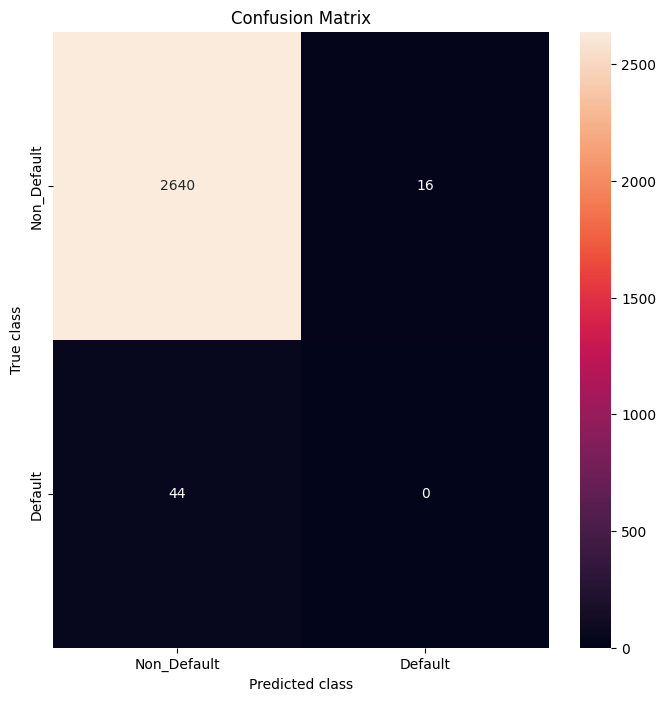

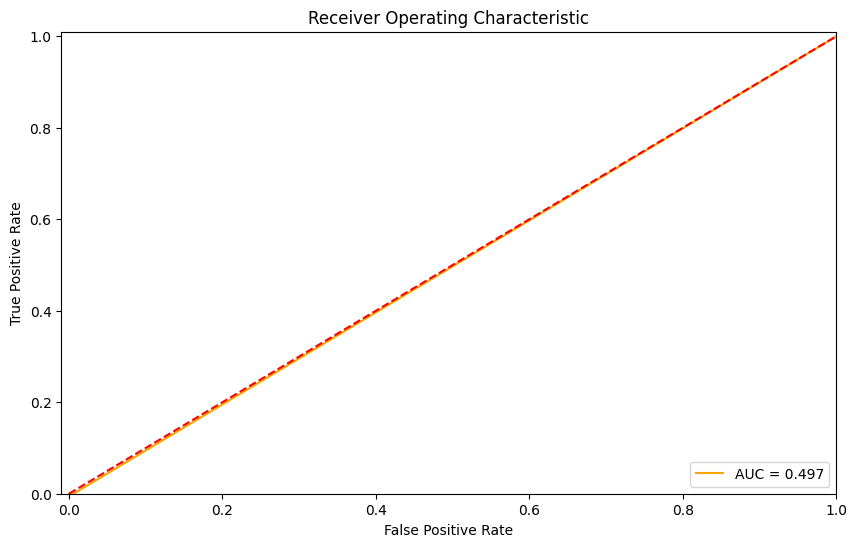

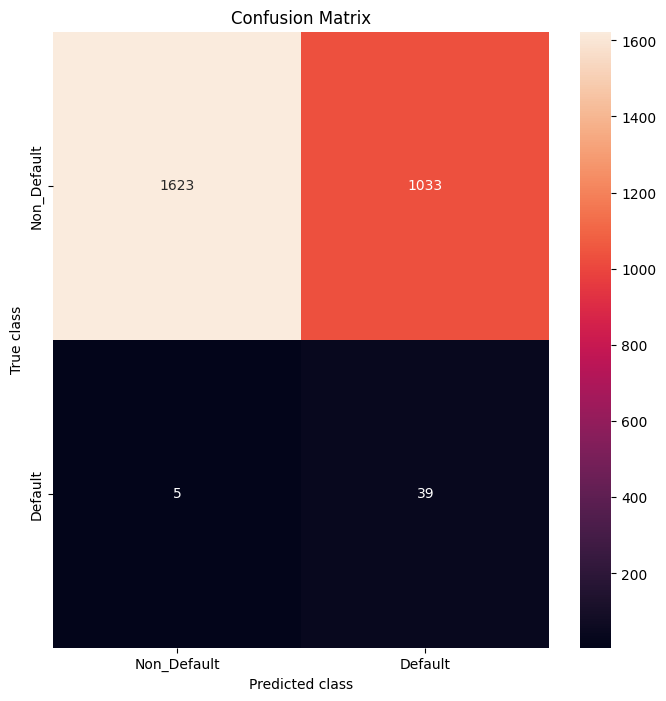

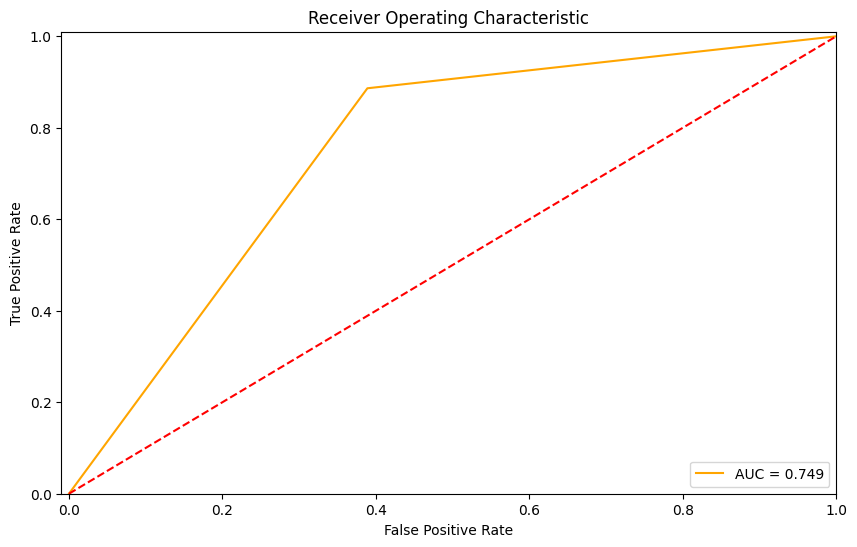

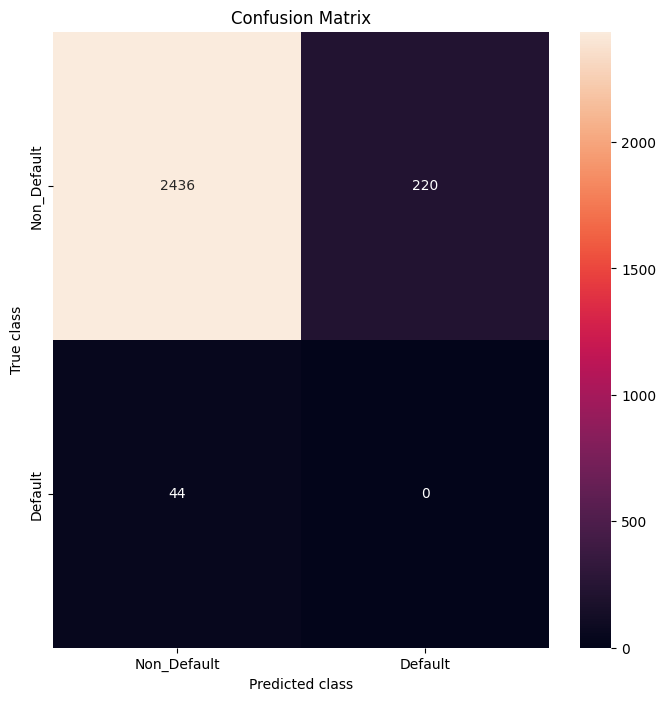

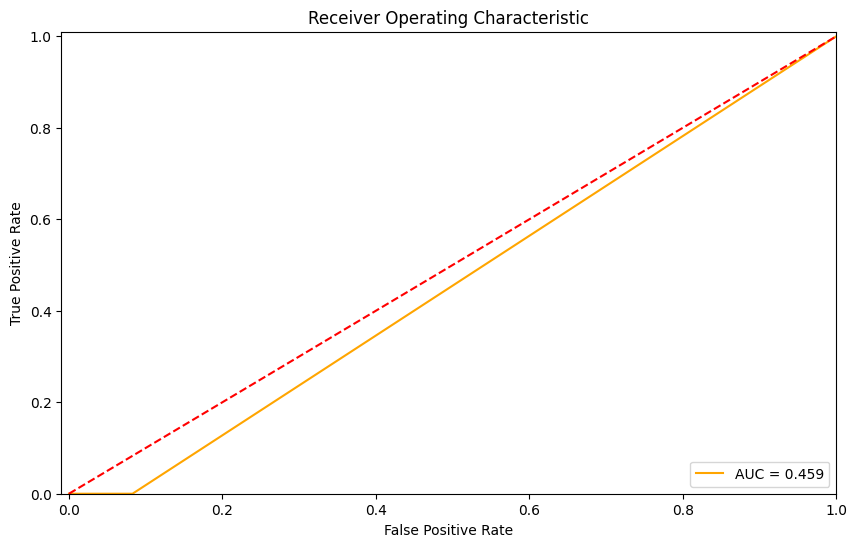

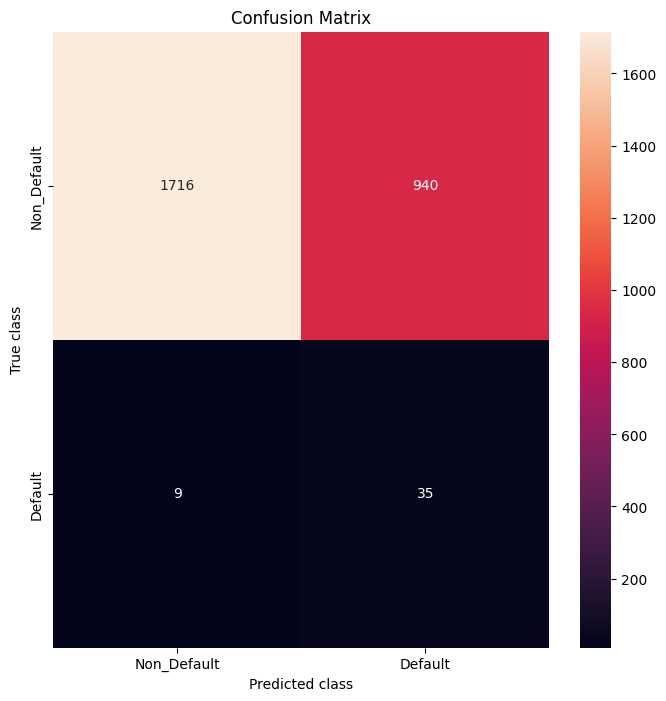

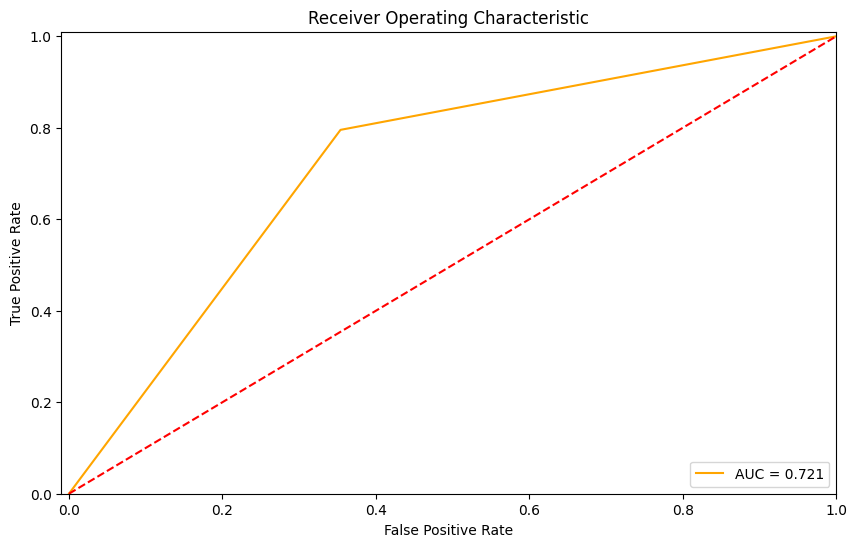

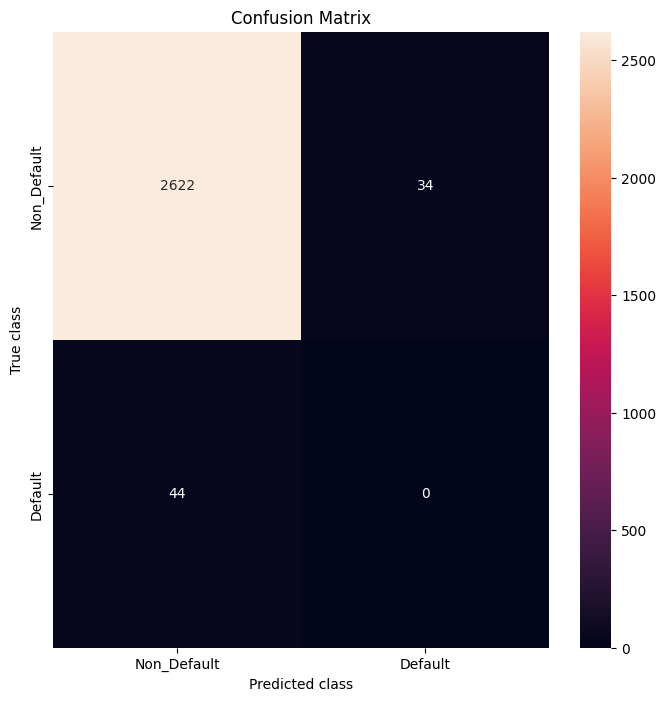

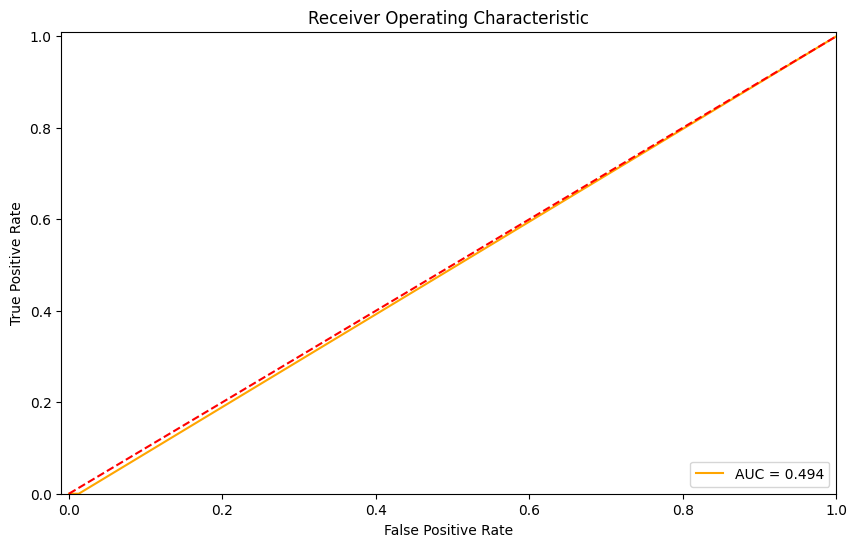

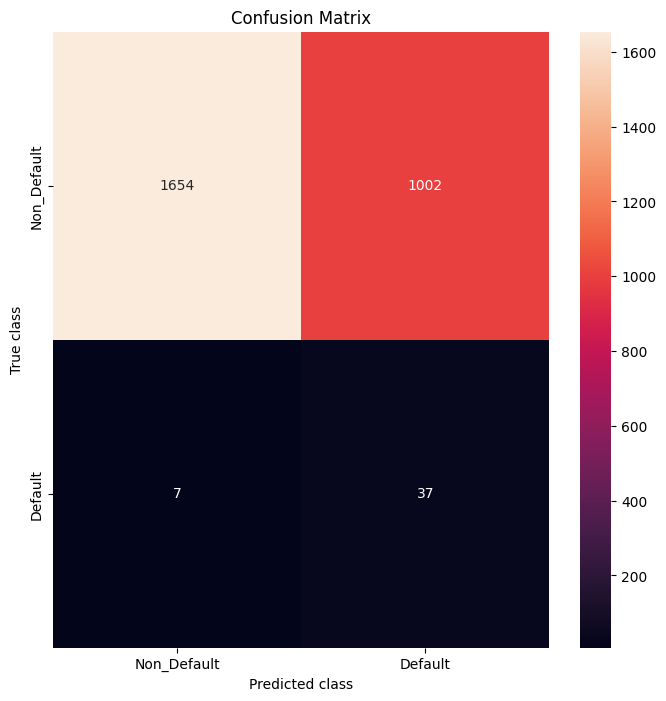

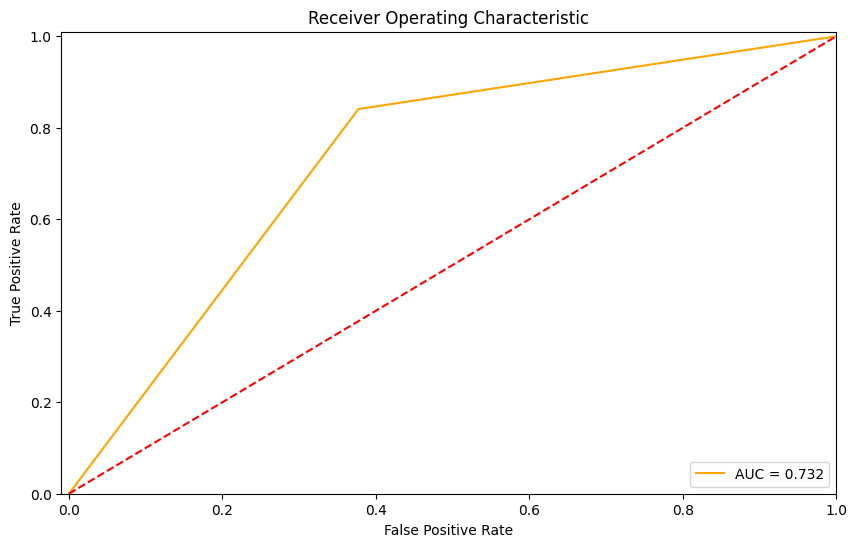

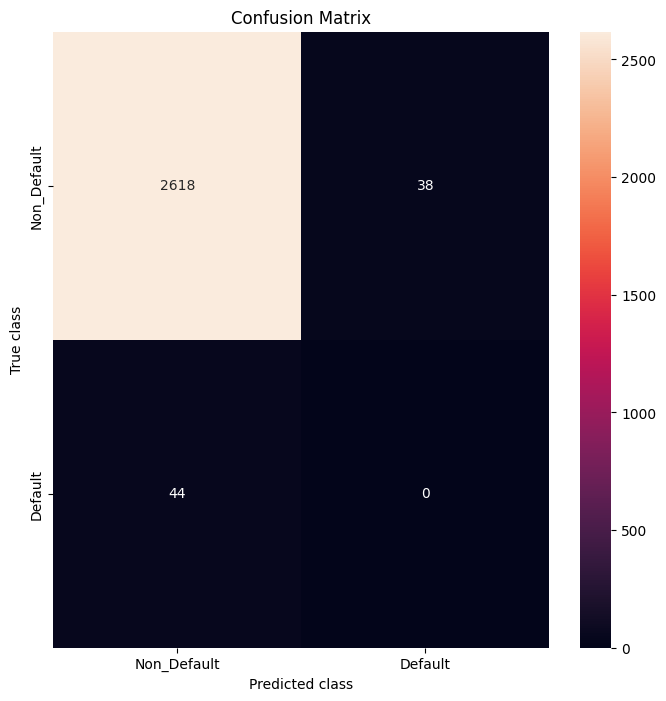

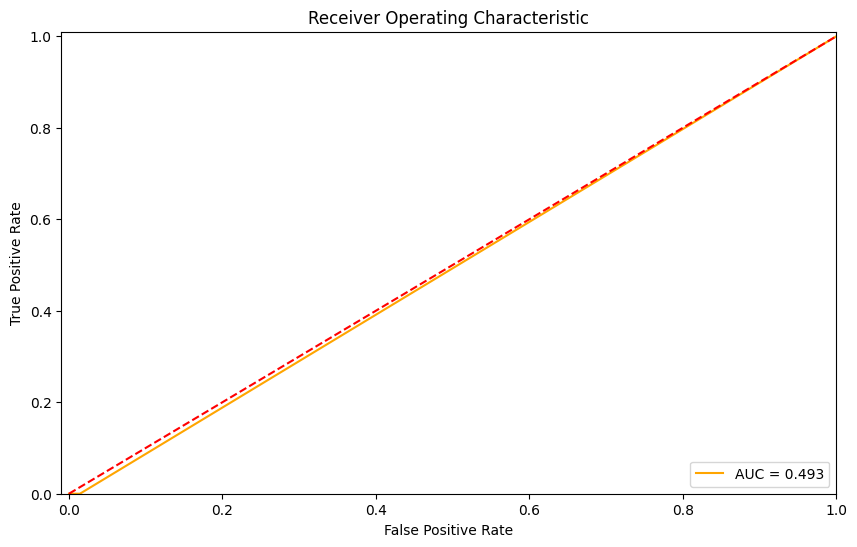

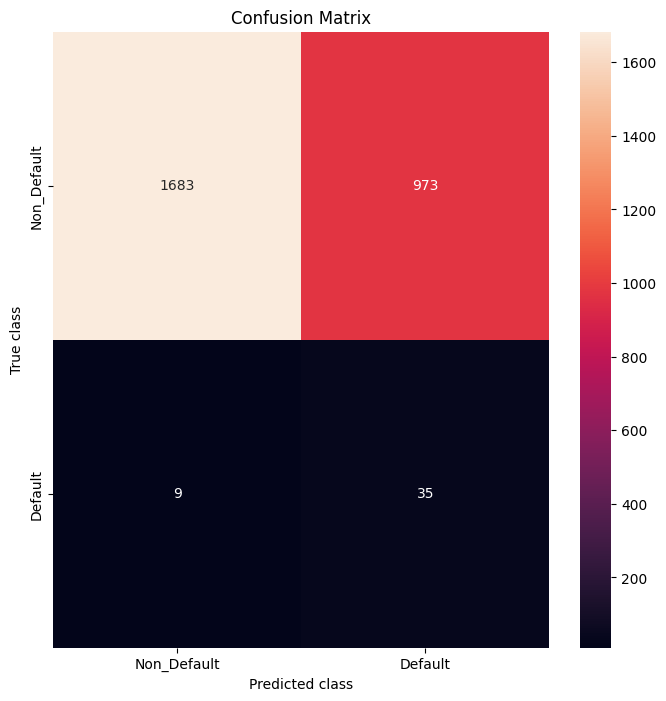

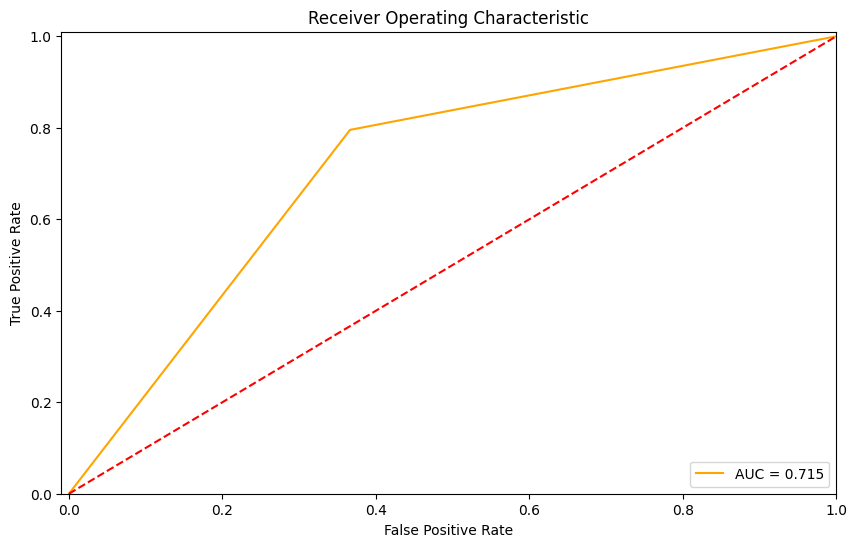

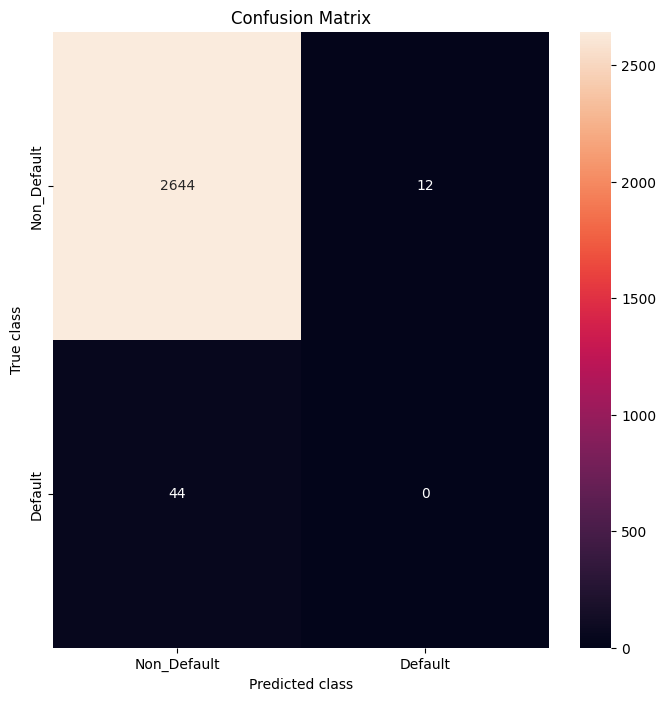

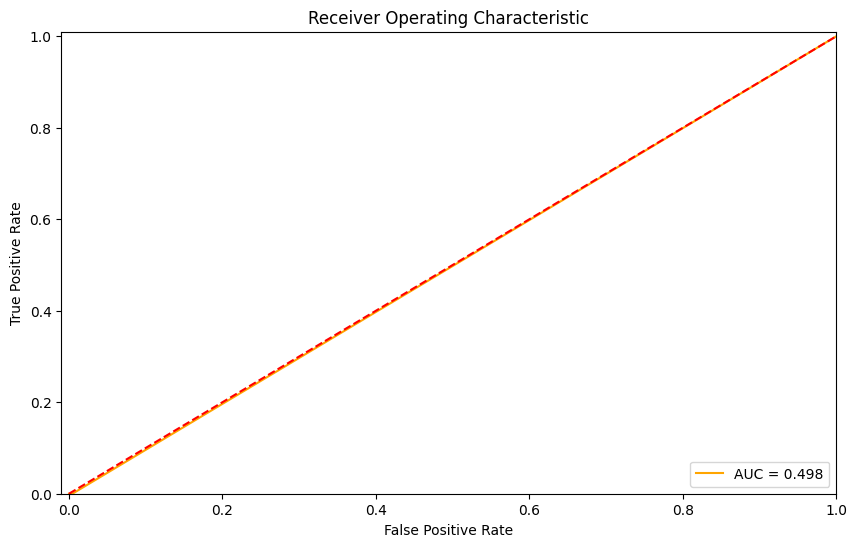

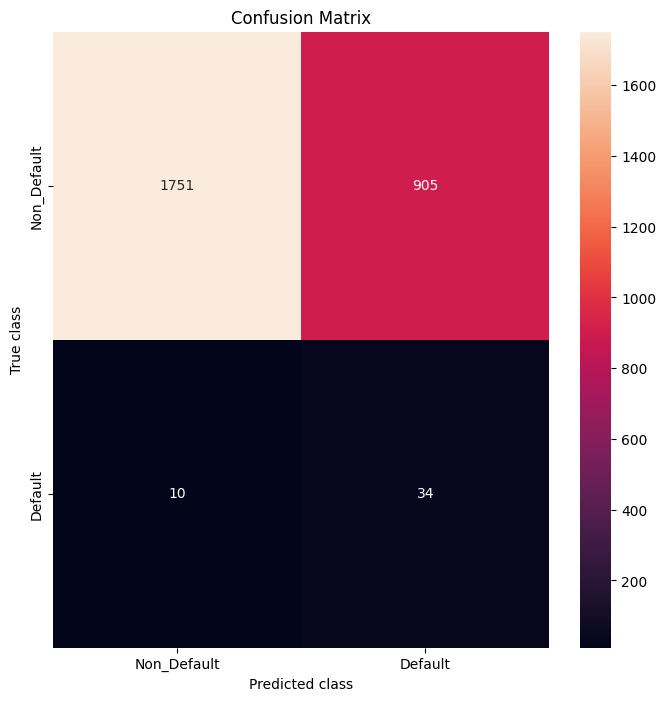

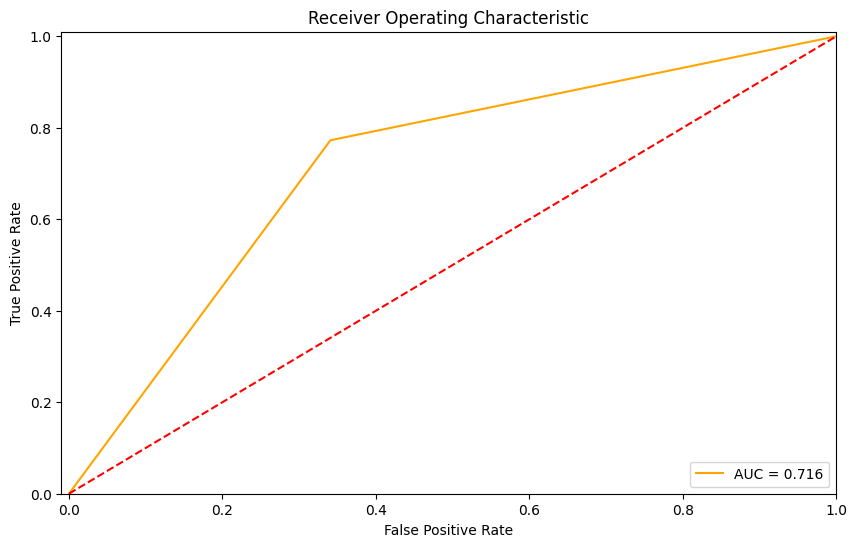

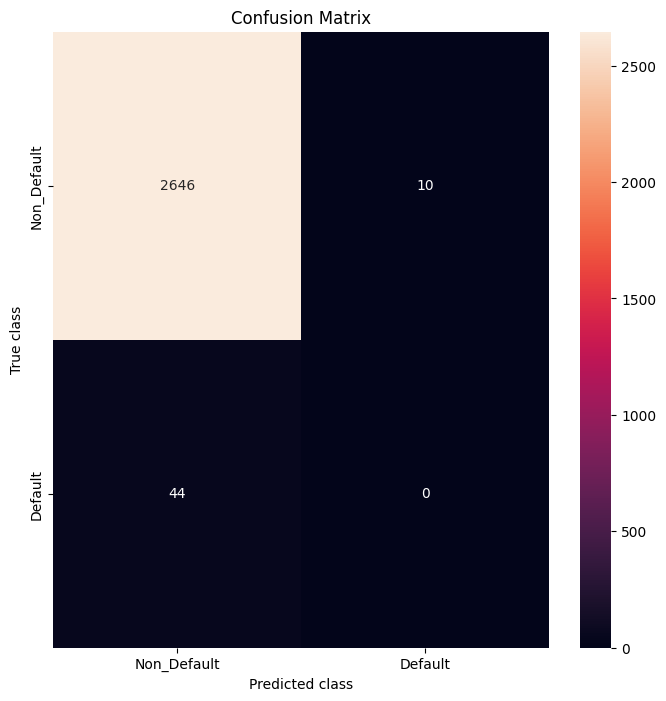

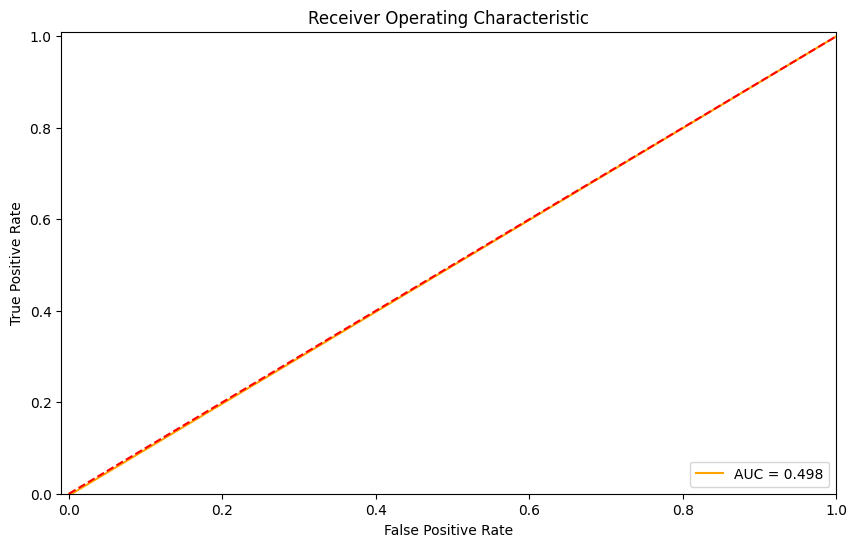

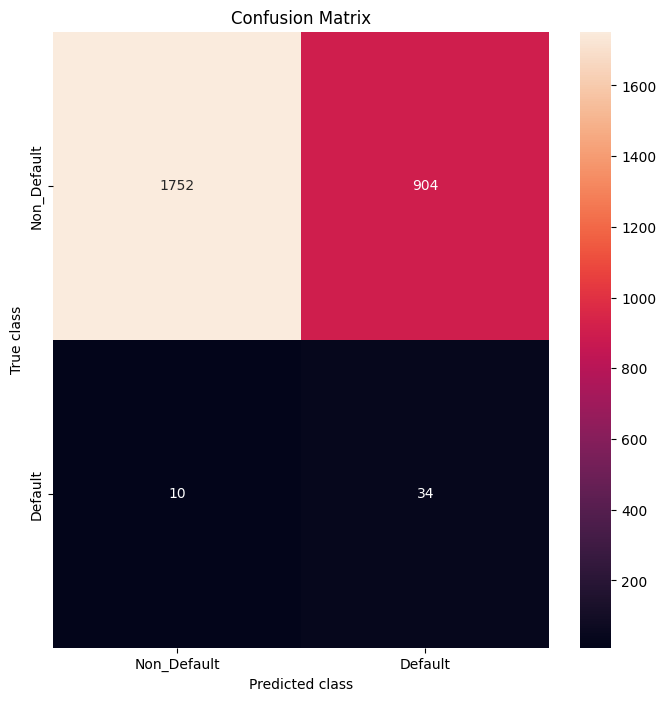

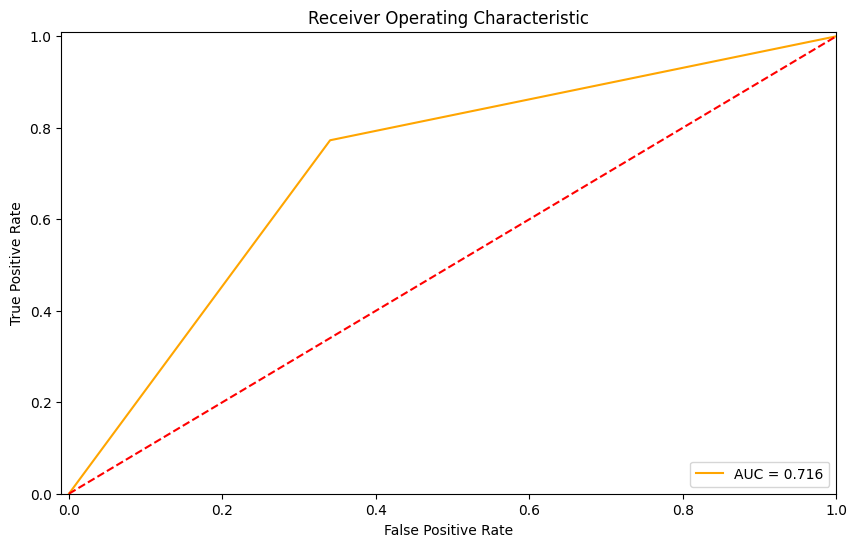

In [19]:
n_tasks = [10, 50, 100]
n_shots = [1, 2, 5, 10, 30, 50]
n_data = 2700
# 產生 validation data
# X_val, y_val = generate_validation_data(X_train, y_train, n_data, 2, 10, 99)
X_val, y_val = generate_validation_data(X_test, y_test, n_data, 2, 10, 99)
# y_val = y_val.astype(int)
for n_task in n_tasks:
    for n_shot in n_shots:
        file_names = df_model.query(f'n_tasks =="{n_task}" and n_shots == "{n_shot}"').apply(lambda x:'_'.join(x), axis=1).to_list()
        # 讀取 30 組 model 的權重後取平均
        avg_val_models = np.load(f'./maml_model/maml_50_iter_{n_task}_tasks_2_ways_{n_shot}_shots_0.npy', allow_pickle=True)
        # 使用平均模型進行預測
        pred_class = predit_classes(avg_val_models, X_val, n_data=n_data)
        pred_class = pred_class.astype(float)
        best_model = avg_val_models
        min_loss = tf.keras.losses.BinaryCrossentropy()(y_val, pred_class)
        for i in range(1,len(file_names)):
            val_model = np.load(f'./maml_model/{file_names[i]}', allow_pickle=True)#.tolist()
            pred_class = predit_classes(val_model, X_val, n_data=n_data)
            pred_class = pred_class.astype(float)
            loss =  tf.keras.losses.BinaryCrossentropy()(y_val, pred_class)
            # 紀錄 30 組中最佳模型
            if loss < min_loss:
                min_loss = loss
                best_model = val_model
            avg_val_models += val_model
        avg_val_models/=len(file_names)
        
        # 使用平均模型進行預測
        pred_class = predit_classes(avg_val_models, X_val, n_data=n_data)
        print('Average')
        print(f'{n_task} tasks and {n_shot} shots')
        plot_confusion_matrix(y_val, pred_class, save_path=f'./image/CM_test_Average_{n_task}_tasks_{n_shot}_shots')
        plot_roc_curve(y_val, pred_class, save_path=f'./image/ROC_test_Average_{n_task}_tasks_{n_shot}_shots')
        # plot_confusion_matrix(y_val, pred_class)
        # plot_roc_curve(y_val, pred_class)
        # 使用loss模型進行預測
        pred_class = predit_classes(best_model, X_val, n_data=n_data)
        print('Best')
        print(f'{n_task} tasks and {n_shot} shots')
        plot_confusion_matrix(y_val, pred_class, save_path=f'./image/CM_test_Best_{n_task}_tasks_{n_shot}_shots')
        plot_roc_curve(y_val, pred_class, save_path=f'./image/ROC_test_Best_{n_task}_tasks_{n_shot}_shots')
        # plot_confusion_matrix(y_val, pred_class)
        # plot_roc_curve(y_val, pred_class)
